In [5]:
import os
import numpy as np
import torch
from PIL import Image

from torch import nn, optim

import visionutils.transforms as T
from visionutils.engine import train_one_epoch, evaluate
import visionutils.utils

import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

from torchvision.models import resnet18, ResNet18_Weights

import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
class ClusterDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms):
        self.root = root
        self.transforms = transforms
        # load all image files, sorting them to
        # ensure that they are aligned
        self.imgs = list(sorted(os.listdir(os.path.join(root, "indv_freq_tiles"))))
        self.masks = list(sorted(os.listdir(os.path.join(root, "indv_masks"))))

    def __getitem__(self, idx):
        # load images and masks
        img_path = os.path.join(self.root, "indv_freq_tiles", self.imgs[idx])
        mask_path = os.path.join(self.root, "indv_masks", self.masks[idx])
        #img = Image.open(img_path).convert("RGB")
        
        with np.load(img_path) as data:
            img = data['arr_0']
        img = np.array(img, dtype='f')

        # note that we haven't converted the mask to RGB,
        # because each color corresponds to a different instance
        # with 0 being background
        with np.load(mask_path) as data:
            mask = data['arr_0']
        # convert the PIL Image into a numpy array
        mask = np.array(mask)
        # instances are encoded as different colors
        obj_ids = np.unique(mask)
        # first id is the background, so remove it
        obj_ids = obj_ids[1:]
        # split the color-encoded mask into a set
        # of binary masks
        masks = mask == obj_ids[:, None, None]
        # get bounding box coordinates for each mask
        num_objs = len(obj_ids)
        boxes = []
        for i in range(num_objs):
            pos = np.where(masks[i])
            xmin = np.min(pos[1])
            xmax = np.max(pos[1])
            ymin = np.min(pos[0])
            ymax = np.max(pos[0])
            boxes.append([xmin, ymin, xmax, ymax])

        # convert everything into a torch.Tensor
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        # there is only one class
        labels = torch.ones((num_objs,), dtype=torch.int64)
        masks = torch.as_tensor(masks, dtype=torch.uint8)

        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # suppose all instances are not crowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["masks"] = masks
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd
        
        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.imgs)

In [18]:
class WiseDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms):
        self.root = root
        self.transforms = transforms
        # load all image files, sorting them to
        # ensure that they are aligned
        self.imgs = list(sorted(os.listdir(os.path.join(root, "clusters"))))
        self.masks = list(sorted(os.listdir(os.path.join(root, "masks"))))

    def __getitem__(self, idx):
        # load images and masks
        img_path = os.path.join(self.root, "clusters", self.imgs[idx])
        mask_path = os.path.join(self.root, "masks", self.masks[idx])
        #img = Image.open(img_path).convert("RGB")
        
        with np.load(img_path) as data:
            img = data['arr_0']
        img = np.array(img, dtype='f')

        # note that we haven't converted the mask to RGB,
        # because each color corresponds to a different instance
        # with 0 being background
        with np.load(mask_path) as data:
            mask = data['arr_0']
        # convert the PIL Image into a numpy array
        mask = np.array(mask)
        # instances are encoded as different colors
        obj_ids = np.unique(mask)
        # first id is the background, so remove it
        obj_ids = obj_ids[1:]
        # split the color-encoded mask into a set
        # of binary masks
        masks = mask == obj_ids[:, None, None]
        # get bounding box coordinates for each mask
        num_objs = len(obj_ids)
        boxes = []
        for i in range(num_objs):
            pos = np.where(masks[i])
            xmin = np.min(pos[1])
            xmax = np.max(pos[1])
            ymin = np.min(pos[0])
            ymax = np.max(pos[0])
            boxes.append([xmin, ymin, xmax, ymax])

        # convert everything into a torch.Tensor
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        # there is only one class
        labels = torch.ones((num_objs,), dtype=torch.int64)
        masks = torch.as_tensor(masks, dtype=torch.uint8)

        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # suppose all instances are not crowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["masks"] = masks
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd
        
        img = img[...,3]
        
        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.imgs)

In [8]:
def get_transform(train):
    transforms = []
    # converts the image, a PIL image, into a PyTorch Tensor
    transforms.append(T.ToTensor())
    if train:
        # during training, randomly flip the training images
        # and ground-truth for data augmentation
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

In [9]:
def get_instance_segmentation_model(num_classes):
    # load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)

    # get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                       hidden_layer,
                                                       num_classes)

    return model

In [10]:
def get_instance_frcnn_model(num_classes, 
                             backbone_path = "/project/r/rbond/jorlo/ml-clusters/models/torch-act/act-mobilenet.pth"):
    
    backbone_model = torchvision.models.mobilenet_v2()
    backbone_model.fc = nn.Linear(512, 2)

    if backbone_path is not None:
        backbone_model.load_state_dict(torch.load(backbone_path))
    backbone = backbone_model.features
    
    backbone.out_channels = 1280
    # let's make the RPN generate 5 x 3 anchors per spatial
    # location, with 5 different sizes and 3 different aspect
    # ratios. We have a Tuple[Tuple[int]] because each feature
    # map could potentially have different sizes and
    # aspect ratios
    anchor_generator = AnchorGenerator(sizes=((32, 64, 128, 256, 512),),
                                       aspect_ratios=((0.5, 1.0, 2.0),))

    # let's define what are the feature maps that we will
    # use to perform the region of interest cropping, as well as
    # the size of the crop after rescaling.
    # if your backbone returns a Tensor, featmap_names is expected to
    # be [0]. More generally, the backbone should return an
    # OrderedDict[Tensor], and in featmap_names you can choose which
    # feature maps to use.
    roi_pooler = torchvision.ops.MultiScaleRoIAlign(featmap_names=['0'],
                                                    output_size=7,
                                                    sampling_ratio=2)
    

    model = FasterRCNN(backbone,
                   num_classes=2,
                   rpn_anchor_generator=anchor_generator,
                   box_roi_pool=roi_pooler,)
                   #box_score_thresh=0.9)
    
    return model

In [6]:

root = '/project/r/rbond/jorlo/datasets/ACT_tiles/'
len(list(sorted(os.listdir(os.path.join(root, "indv_masks")))))

4195

In [7]:
# use our dataset and defined transformations
dataset = ClusterDataset('/project/r/rbond/jorlo/datasets/ACT_tiles/', get_transform(train=True))
dataset_test = ClusterDataset('/project/r/rbond/jorlo/datasets/ACT_tiles/', get_transform(train=False))

# split the dataset in train and test set
torch.manual_seed(1)
indices = torch.randperm(len(dataset)).tolist()
dataset = torch.utils.data.Subset(dataset, indices[:-50])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-50:])

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=2, shuffle=True, num_workers=4,
    collate_fn=visionutils.utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=1, shuffle=False, num_workers=4,
    collate_fn=visionutils.utils.collate_fn)

In [8]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# our dataset has two classes only - background and person
num_classes = 2

# get the model using our helper function
model = get_instance_frcnn_model(num_classes)
# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)

# and a learning rate scheduler which decreases the learning rate by
# 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

In [9]:
# let's train it for 10 epochs
from torch.optim.lr_scheduler import StepLR
num_epochs = 10

model.load_state_dict(torch.load("/project/r/rbond/jorlo/ml-clusters/models/torch-act/act-mobilenet-frcnn.pth"))

for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, data_loader_test, device=device)
    torch.save(model.state_dict(), "/project/r/rbond/jorlo/ml-clusters/models/torch-act/act-mobilenet-frcnn.pth")


Epoch: [0]  [   0/2073]  eta: 15:12:21  lr: 0.000010  loss: 0.0246 (0.0246)  loss_classifier: 0.0097 (0.0097)  loss_box_reg: 0.0145 (0.0145)  loss_objectness: 0.0004 (0.0004)  loss_rpn_box_reg: 0.0001 (0.0001)  time: 26.4070  data: 0.3035  max mem: 3000
Epoch: [0]  [  10/2073]  eta: 1:26:45  lr: 0.000060  loss: 0.0463 (0.0510)  loss_classifier: 0.0185 (0.0200)  loss_box_reg: 0.0252 (0.0281)  loss_objectness: 0.0011 (0.0027)  loss_rpn_box_reg: 0.0001 (0.0002)  time: 2.5233  data: 0.0384  max mem: 3628
Epoch: [0]  [  20/2073]  eta: 0:47:13  lr: 0.000110  loss: 0.0491 (0.0548)  loss_classifier: 0.0185 (0.0225)  loss_box_reg: 0.0275 (0.0295)  loss_objectness: 0.0009 (0.0027)  loss_rpn_box_reg: 0.0001 (0.0002)  time: 0.1289  data: 0.0085  max mem: 3628
Epoch: [0]  [  30/2073]  eta: 0:33:13  lr: 0.000160  loss: 0.0466 (0.0494)  loss_classifier: 0.0147 (0.0199)  loss_box_reg: 0.0247 (0.0269)  loss_objectness: 0.0005 (0.0024)  loss_rpn_box_reg: 0.0001 (0.0002)  time: 0.1246  data: 0.0068  max 

Epoch: [0]  [ 330/2073]  eta: 0:05:55  lr: 0.001658  loss: 0.0500 (0.0496)  loss_classifier: 0.0180 (0.0186)  loss_box_reg: 0.0302 (0.0288)  loss_objectness: 0.0005 (0.0019)  loss_rpn_box_reg: 0.0002 (0.0002)  time: 0.1242  data: 0.0054  max mem: 3628
Epoch: [0]  [ 340/2073]  eta: 0:05:48  lr: 0.001708  loss: 0.0456 (0.0494)  loss_classifier: 0.0162 (0.0185)  loss_box_reg: 0.0281 (0.0288)  loss_objectness: 0.0006 (0.0019)  loss_rpn_box_reg: 0.0003 (0.0002)  time: 0.1228  data: 0.0051  max mem: 3628
Epoch: [0]  [ 350/2073]  eta: 0:05:42  lr: 0.001758  loss: 0.0434 (0.0493)  loss_classifier: 0.0157 (0.0184)  loss_box_reg: 0.0257 (0.0288)  loss_objectness: 0.0006 (0.0019)  loss_rpn_box_reg: 0.0002 (0.0002)  time: 0.1225  data: 0.0050  max mem: 3628
Epoch: [0]  [ 360/2073]  eta: 0:05:37  lr: 0.001808  loss: 0.0447 (0.0497)  loss_classifier: 0.0170 (0.0185)  loss_box_reg: 0.0273 (0.0291)  loss_objectness: 0.0006 (0.0019)  loss_rpn_box_reg: 0.0002 (0.0002)  time: 0.1225  data: 0.0050  max me

Epoch: [0]  [ 660/2073]  eta: 0:03:51  lr: 0.003307  loss: 0.0376 (0.0487)  loss_classifier: 0.0124 (0.0179)  loss_box_reg: 0.0231 (0.0288)  loss_objectness: 0.0004 (0.0017)  loss_rpn_box_reg: 0.0002 (0.0002)  time: 0.1224  data: 0.0051  max mem: 3628
Epoch: [0]  [ 670/2073]  eta: 0:03:48  lr: 0.003357  loss: 0.0370 (0.0486)  loss_classifier: 0.0125 (0.0179)  loss_box_reg: 0.0232 (0.0288)  loss_objectness: 0.0005 (0.0017)  loss_rpn_box_reg: 0.0002 (0.0002)  time: 0.1224  data: 0.0050  max mem: 3628
Epoch: [0]  [ 680/2073]  eta: 0:03:46  lr: 0.003407  loss: 0.0357 (0.0485)  loss_classifier: 0.0131 (0.0178)  loss_box_reg: 0.0226 (0.0287)  loss_objectness: 0.0005 (0.0017)  loss_rpn_box_reg: 0.0002 (0.0002)  time: 0.1229  data: 0.0051  max mem: 3628
Epoch: [0]  [ 690/2073]  eta: 0:03:44  lr: 0.003457  loss: 0.0344 (0.0485)  loss_classifier: 0.0130 (0.0178)  loss_box_reg: 0.0222 (0.0287)  loss_objectness: 0.0005 (0.0017)  loss_rpn_box_reg: 0.0002 (0.0002)  time: 0.1241  data: 0.0055  max me

Epoch: [0]  [ 990/2073]  eta: 0:02:42  lr: 0.004955  loss: 0.0516 (0.0491)  loss_classifier: 0.0164 (0.0181)  loss_box_reg: 0.0320 (0.0291)  loss_objectness: 0.0005 (0.0017)  loss_rpn_box_reg: 0.0002 (0.0002)  time: 0.1227  data: 0.0050  max mem: 3628
Epoch: [0]  [1000/2073]  eta: 0:02:41  lr: 0.005000  loss: 0.0522 (0.0492)  loss_classifier: 0.0180 (0.0181)  loss_box_reg: 0.0344 (0.0292)  loss_objectness: 0.0008 (0.0017)  loss_rpn_box_reg: 0.0003 (0.0002)  time: 0.1231  data: 0.0051  max mem: 3628
Epoch: [0]  [1010/2073]  eta: 0:02:39  lr: 0.005000  loss: 0.0522 (0.0492)  loss_classifier: 0.0180 (0.0181)  loss_box_reg: 0.0344 (0.0292)  loss_objectness: 0.0006 (0.0017)  loss_rpn_box_reg: 0.0002 (0.0002)  time: 0.1236  data: 0.0052  max mem: 3628
Epoch: [0]  [1020/2073]  eta: 0:02:37  lr: 0.005000  loss: 0.0411 (0.0492)  loss_classifier: 0.0144 (0.0181)  loss_box_reg: 0.0263 (0.0292)  loss_objectness: 0.0006 (0.0017)  loss_rpn_box_reg: 0.0003 (0.0002)  time: 0.1236  data: 0.0052  max me

Epoch: [0]  [1320/2073]  eta: 0:01:48  lr: 0.005000  loss: 0.0446 (0.0508)  loss_classifier: 0.0145 (0.0187)  loss_box_reg: 0.0278 (0.0302)  loss_objectness: 0.0007 (0.0017)  loss_rpn_box_reg: 0.0001 (0.0002)  time: 0.1244  data: 0.0055  max mem: 3628
Epoch: [0]  [1330/2073]  eta: 0:01:46  lr: 0.005000  loss: 0.0527 (0.0508)  loss_classifier: 0.0155 (0.0187)  loss_box_reg: 0.0314 (0.0302)  loss_objectness: 0.0008 (0.0017)  loss_rpn_box_reg: 0.0001 (0.0002)  time: 0.1240  data: 0.0055  max mem: 3628
Epoch: [0]  [1340/2073]  eta: 0:01:45  lr: 0.005000  loss: 0.0537 (0.0510)  loss_classifier: 0.0177 (0.0187)  loss_box_reg: 0.0372 (0.0303)  loss_objectness: 0.0015 (0.0017)  loss_rpn_box_reg: 0.0002 (0.0002)  time: 0.1241  data: 0.0055  max mem: 3628
Epoch: [0]  [1350/2073]  eta: 0:01:43  lr: 0.005000  loss: 0.0595 (0.0511)  loss_classifier: 0.0212 (0.0188)  loss_box_reg: 0.0372 (0.0303)  loss_objectness: 0.0014 (0.0017)  loss_rpn_box_reg: 0.0002 (0.0002)  time: 0.1240  data: 0.0054  max me

Epoch: [0]  [1650/2073]  eta: 0:00:59  lr: 0.005000  loss: 0.0599 (0.0523)  loss_classifier: 0.0244 (0.0192)  loss_box_reg: 0.0331 (0.0312)  loss_objectness: 0.0009 (0.0017)  loss_rpn_box_reg: 0.0002 (0.0002)  time: 0.1425  data: 0.0172  max mem: 3628
Epoch: [0]  [1660/2073]  eta: 0:00:57  lr: 0.005000  loss: 0.0530 (0.0524)  loss_classifier: 0.0195 (0.0193)  loss_box_reg: 0.0304 (0.0312)  loss_objectness: 0.0007 (0.0017)  loss_rpn_box_reg: 0.0002 (0.0002)  time: 0.1335  data: 0.0102  max mem: 3628
Epoch: [0]  [1670/2073]  eta: 0:00:56  lr: 0.005000  loss: 0.0466 (0.0524)  loss_classifier: 0.0172 (0.0192)  loss_box_reg: 0.0290 (0.0312)  loss_objectness: 0.0005 (0.0017)  loss_rpn_box_reg: 0.0002 (0.0002)  time: 0.1237  data: 0.0054  max mem: 3628
Epoch: [0]  [1680/2073]  eta: 0:00:55  lr: 0.005000  loss: 0.0466 (0.0524)  loss_classifier: 0.0172 (0.0192)  loss_box_reg: 0.0304 (0.0312)  loss_objectness: 0.0005 (0.0017)  loss_rpn_box_reg: 0.0002 (0.0002)  time: 0.1237  data: 0.0054  max me

Epoch: [0]  [1980/2073]  eta: 0:00:12  lr: 0.005000  loss: 0.0568 (0.0532)  loss_classifier: 0.0206 (0.0196)  loss_box_reg: 0.0330 (0.0316)  loss_objectness: 0.0007 (0.0018)  loss_rpn_box_reg: 0.0001 (0.0002)  time: 0.1238  data: 0.0055  max mem: 3628
Epoch: [0]  [1990/2073]  eta: 0:00:11  lr: 0.005000  loss: 0.0489 (0.0533)  loss_classifier: 0.0198 (0.0196)  loss_box_reg: 0.0339 (0.0316)  loss_objectness: 0.0006 (0.0018)  loss_rpn_box_reg: 0.0003 (0.0002)  time: 0.1237  data: 0.0054  max mem: 3628
Epoch: [0]  [2000/2073]  eta: 0:00:10  lr: 0.005000  loss: 0.0460 (0.0532)  loss_classifier: 0.0167 (0.0196)  loss_box_reg: 0.0290 (0.0316)  loss_objectness: 0.0006 (0.0018)  loss_rpn_box_reg: 0.0002 (0.0002)  time: 0.1237  data: 0.0054  max mem: 3628
Epoch: [0]  [2010/2073]  eta: 0:00:08  lr: 0.005000  loss: 0.0470 (0.0533)  loss_classifier: 0.0167 (0.0196)  loss_box_reg: 0.0298 (0.0317)  loss_objectness: 0.0006 (0.0018)  loss_rpn_box_reg: 0.0002 (0.0002)  time: 0.1239  data: 0.0055  max me

Epoch: [1]  [ 160/2073]  eta: 0:04:00  lr: 0.005000  loss: 0.0538 (0.0555)  loss_classifier: 0.0172 (0.0202)  loss_box_reg: 0.0343 (0.0333)  loss_objectness: 0.0005 (0.0017)  loss_rpn_box_reg: 0.0002 (0.0003)  time: 0.1234  data: 0.0050  max mem: 3628
Epoch: [1]  [ 170/2073]  eta: 0:03:58  lr: 0.005000  loss: 0.0507 (0.0562)  loss_classifier: 0.0173 (0.0204)  loss_box_reg: 0.0329 (0.0338)  loss_objectness: 0.0006 (0.0018)  loss_rpn_box_reg: 0.0002 (0.0003)  time: 0.1243  data: 0.0053  max mem: 3628
Epoch: [1]  [ 180/2073]  eta: 0:03:57  lr: 0.005000  loss: 0.0521 (0.0569)  loss_classifier: 0.0187 (0.0206)  loss_box_reg: 0.0281 (0.0342)  loss_objectness: 0.0010 (0.0019)  loss_rpn_box_reg: 0.0001 (0.0002)  time: 0.1243  data: 0.0053  max mem: 3628
Epoch: [1]  [ 190/2073]  eta: 0:03:55  lr: 0.005000  loss: 0.0604 (0.0578)  loss_classifier: 0.0223 (0.0211)  loss_box_reg: 0.0364 (0.0345)  loss_objectness: 0.0010 (0.0020)  loss_rpn_box_reg: 0.0001 (0.0003)  time: 0.1235  data: 0.0050  max me

Epoch: [1]  [ 490/2073]  eta: 0:03:17  lr: 0.005000  loss: 0.0688 (0.0602)  loss_classifier: 0.0240 (0.0226)  loss_box_reg: 0.0366 (0.0351)  loss_objectness: 0.0014 (0.0023)  loss_rpn_box_reg: 0.0002 (0.0002)  time: 0.1238  data: 0.0051  max mem: 3628
Epoch: [1]  [ 500/2073]  eta: 0:03:16  lr: 0.005000  loss: 0.0586 (0.0603)  loss_classifier: 0.0195 (0.0227)  loss_box_reg: 0.0348 (0.0350)  loss_objectness: 0.0028 (0.0024)  loss_rpn_box_reg: 0.0002 (0.0002)  time: 0.1238  data: 0.0051  max mem: 3628
Epoch: [1]  [ 510/2073]  eta: 0:03:14  lr: 0.005000  loss: 0.0550 (0.0601)  loss_classifier: 0.0181 (0.0226)  loss_box_reg: 0.0314 (0.0349)  loss_objectness: 0.0014 (0.0023)  loss_rpn_box_reg: 0.0002 (0.0003)  time: 0.1240  data: 0.0050  max mem: 3628
Epoch: [1]  [ 520/2073]  eta: 0:03:13  lr: 0.005000  loss: 0.0514 (0.0602)  loss_classifier: 0.0173 (0.0225)  loss_box_reg: 0.0347 (0.0351)  loss_objectness: 0.0007 (0.0023)  loss_rpn_box_reg: 0.0003 (0.0003)  time: 0.1240  data: 0.0050  max me

Epoch: [1]  [ 820/2073]  eta: 0:02:36  lr: 0.005000  loss: 0.0613 (0.0608)  loss_classifier: 0.0234 (0.0230)  loss_box_reg: 0.0337 (0.0353)  loss_objectness: 0.0019 (0.0023)  loss_rpn_box_reg: 0.0002 (0.0003)  time: 0.1239  data: 0.0052  max mem: 3628
Epoch: [1]  [ 830/2073]  eta: 0:02:35  lr: 0.005000  loss: 0.0576 (0.0608)  loss_classifier: 0.0234 (0.0230)  loss_box_reg: 0.0346 (0.0353)  loss_objectness: 0.0011 (0.0023)  loss_rpn_box_reg: 0.0002 (0.0003)  time: 0.1243  data: 0.0051  max mem: 3628
Epoch: [1]  [ 840/2073]  eta: 0:02:33  lr: 0.005000  loss: 0.0614 (0.0610)  loss_classifier: 0.0244 (0.0231)  loss_box_reg: 0.0346 (0.0353)  loss_objectness: 0.0008 (0.0023)  loss_rpn_box_reg: 0.0002 (0.0003)  time: 0.1246  data: 0.0051  max mem: 3628
Epoch: [1]  [ 850/2073]  eta: 0:02:32  lr: 0.005000  loss: 0.0643 (0.0610)  loss_classifier: 0.0241 (0.0231)  loss_box_reg: 0.0392 (0.0353)  loss_objectness: 0.0008 (0.0023)  loss_rpn_box_reg: 0.0002 (0.0003)  time: 0.1247  data: 0.0053  max me

Epoch: [1]  [1150/2073]  eta: 0:01:55  lr: 0.005000  loss: 0.0515 (0.0603)  loss_classifier: 0.0185 (0.0228)  loss_box_reg: 0.0327 (0.0350)  loss_objectness: 0.0009 (0.0022)  loss_rpn_box_reg: 0.0001 (0.0003)  time: 0.1267  data: 0.0055  max mem: 3628
Epoch: [1]  [1160/2073]  eta: 0:01:53  lr: 0.005000  loss: 0.0546 (0.0603)  loss_classifier: 0.0178 (0.0228)  loss_box_reg: 0.0335 (0.0350)  loss_objectness: 0.0007 (0.0022)  loss_rpn_box_reg: 0.0001 (0.0003)  time: 0.1312  data: 0.0062  max mem: 3628
Epoch: [1]  [1170/2073]  eta: 0:01:52  lr: 0.005000  loss: 0.0553 (0.0603)  loss_classifier: 0.0203 (0.0228)  loss_box_reg: 0.0374 (0.0350)  loss_objectness: 0.0008 (0.0022)  loss_rpn_box_reg: 0.0002 (0.0003)  time: 0.1324  data: 0.0068  max mem: 3628
Epoch: [1]  [1180/2073]  eta: 0:01:51  lr: 0.005000  loss: 0.0553 (0.0603)  loss_classifier: 0.0208 (0.0228)  loss_box_reg: 0.0334 (0.0350)  loss_objectness: 0.0008 (0.0022)  loss_rpn_box_reg: 0.0002 (0.0003)  time: 0.1279  data: 0.0060  max me

Epoch: [1]  [1480/2073]  eta: 0:01:14  lr: 0.005000  loss: 0.0583 (0.0604)  loss_classifier: 0.0265 (0.0229)  loss_box_reg: 0.0372 (0.0350)  loss_objectness: 0.0008 (0.0023)  loss_rpn_box_reg: 0.0003 (0.0003)  time: 0.1253  data: 0.0050  max mem: 3628
Epoch: [1]  [1490/2073]  eta: 0:01:12  lr: 0.005000  loss: 0.0537 (0.0604)  loss_classifier: 0.0203 (0.0229)  loss_box_reg: 0.0372 (0.0350)  loss_objectness: 0.0006 (0.0023)  loss_rpn_box_reg: 0.0002 (0.0003)  time: 0.1266  data: 0.0056  max mem: 3628
Epoch: [1]  [1500/2073]  eta: 0:01:11  lr: 0.005000  loss: 0.0612 (0.0604)  loss_classifier: 0.0205 (0.0229)  loss_box_reg: 0.0373 (0.0350)  loss_objectness: 0.0009 (0.0023)  loss_rpn_box_reg: 0.0002 (0.0003)  time: 0.1289  data: 0.0061  max mem: 3628
Epoch: [1]  [1510/2073]  eta: 0:01:10  lr: 0.005000  loss: 0.0607 (0.0604)  loss_classifier: 0.0232 (0.0229)  loss_box_reg: 0.0311 (0.0350)  loss_objectness: 0.0008 (0.0022)  loss_rpn_box_reg: 0.0002 (0.0003)  time: 0.1270  data: 0.0057  max me

Epoch: [1]  [1810/2073]  eta: 0:00:32  lr: 0.005000  loss: 0.0600 (0.0603)  loss_classifier: 0.0209 (0.0229)  loss_box_reg: 0.0351 (0.0349)  loss_objectness: 0.0011 (0.0022)  loss_rpn_box_reg: 0.0002 (0.0003)  time: 0.1245  data: 0.0052  max mem: 3628
Epoch: [1]  [1820/2073]  eta: 0:00:31  lr: 0.005000  loss: 0.0563 (0.0603)  loss_classifier: 0.0203 (0.0229)  loss_box_reg: 0.0321 (0.0349)  loss_objectness: 0.0008 (0.0022)  loss_rpn_box_reg: 0.0002 (0.0003)  time: 0.1243  data: 0.0052  max mem: 3628
Epoch: [1]  [1830/2073]  eta: 0:00:30  lr: 0.005000  loss: 0.0522 (0.0604)  loss_classifier: 0.0197 (0.0230)  loss_box_reg: 0.0295 (0.0349)  loss_objectness: 0.0010 (0.0022)  loss_rpn_box_reg: 0.0002 (0.0003)  time: 0.1244  data: 0.0051  max mem: 3628
Epoch: [1]  [1840/2073]  eta: 0:00:29  lr: 0.005000  loss: 0.0498 (0.0603)  loss_classifier: 0.0197 (0.0229)  loss_box_reg: 0.0301 (0.0349)  loss_objectness: 0.0010 (0.0022)  loss_rpn_box_reg: 0.0002 (0.0003)  time: 0.1244  data: 0.0051  max me

Epoch: [2]  [   0/2073]  eta: 0:11:47  lr: 0.005000  loss: 0.0597 (0.0597)  loss_classifier: 0.0245 (0.0245)  loss_box_reg: 0.0332 (0.0332)  loss_objectness: 0.0017 (0.0017)  loss_rpn_box_reg: 0.0002 (0.0002)  time: 0.3413  data: 0.2083  max mem: 3628
Epoch: [2]  [  10/2073]  eta: 0:04:56  lr: 0.005000  loss: 0.0670 (0.0758)  loss_classifier: 0.0245 (0.0327)  loss_box_reg: 0.0353 (0.0395)  loss_objectness: 0.0017 (0.0033)  loss_rpn_box_reg: 0.0002 (0.0003)  time: 0.1439  data: 0.0237  max mem: 3628
Epoch: [2]  [  20/2073]  eta: 0:04:36  lr: 0.005000  loss: 0.0657 (0.0689)  loss_classifier: 0.0217 (0.0304)  loss_box_reg: 0.0342 (0.0353)  loss_objectness: 0.0015 (0.0029)  loss_rpn_box_reg: 0.0002 (0.0003)  time: 0.1243  data: 0.0052  max mem: 3628
Epoch: [2]  [  30/2073]  eta: 0:04:29  lr: 0.005000  loss: 0.0483 (0.0619)  loss_classifier: 0.0182 (0.0267)  loss_box_reg: 0.0281 (0.0325)  loss_objectness: 0.0008 (0.0025)  loss_rpn_box_reg: 0.0002 (0.0002)  time: 0.1255  data: 0.0054  max me

Epoch: [2]  [ 330/2073]  eta: 0:03:38  lr: 0.005000  loss: 0.0460 (0.0577)  loss_classifier: 0.0182 (0.0232)  loss_box_reg: 0.0273 (0.0321)  loss_objectness: 0.0007 (0.0022)  loss_rpn_box_reg: 0.0002 (0.0002)  time: 0.1246  data: 0.0050  max mem: 3628
Epoch: [2]  [ 340/2073]  eta: 0:03:36  lr: 0.005000  loss: 0.0645 (0.0581)  loss_classifier: 0.0185 (0.0233)  loss_box_reg: 0.0399 (0.0324)  loss_objectness: 0.0010 (0.0022)  loss_rpn_box_reg: 0.0002 (0.0002)  time: 0.1236  data: 0.0050  max mem: 3628
Epoch: [2]  [ 350/2073]  eta: 0:03:35  lr: 0.005000  loss: 0.0767 (0.0585)  loss_classifier: 0.0253 (0.0234)  loss_box_reg: 0.0432 (0.0326)  loss_objectness: 0.0007 (0.0022)  loss_rpn_box_reg: 0.0003 (0.0002)  time: 0.1239  data: 0.0050  max mem: 3628
Epoch: [2]  [ 360/2073]  eta: 0:03:34  lr: 0.005000  loss: 0.0479 (0.0582)  loss_classifier: 0.0199 (0.0232)  loss_box_reg: 0.0293 (0.0325)  loss_objectness: 0.0005 (0.0022)  loss_rpn_box_reg: 0.0002 (0.0002)  time: 0.1239  data: 0.0050  max me

Epoch: [2]  [ 660/2073]  eta: 0:02:55  lr: 0.005000  loss: 0.0569 (0.0593)  loss_classifier: 0.0205 (0.0232)  loss_box_reg: 0.0356 (0.0335)  loss_objectness: 0.0010 (0.0024)  loss_rpn_box_reg: 0.0003 (0.0002)  time: 0.1263  data: 0.0055  max mem: 3628
Epoch: [2]  [ 670/2073]  eta: 0:02:54  lr: 0.005000  loss: 0.0556 (0.0592)  loss_classifier: 0.0186 (0.0231)  loss_box_reg: 0.0358 (0.0335)  loss_objectness: 0.0009 (0.0023)  loss_rpn_box_reg: 0.0002 (0.0002)  time: 0.1258  data: 0.0054  max mem: 3628
Epoch: [2]  [ 680/2073]  eta: 0:02:53  lr: 0.005000  loss: 0.0602 (0.0593)  loss_classifier: 0.0199 (0.0231)  loss_box_reg: 0.0374 (0.0336)  loss_objectness: 0.0009 (0.0023)  loss_rpn_box_reg: 0.0002 (0.0002)  time: 0.1250  data: 0.0053  max mem: 3628
Epoch: [2]  [ 690/2073]  eta: 0:02:52  lr: 0.005000  loss: 0.0602 (0.0592)  loss_classifier: 0.0199 (0.0231)  loss_box_reg: 0.0346 (0.0336)  loss_objectness: 0.0009 (0.0023)  loss_rpn_box_reg: 0.0002 (0.0002)  time: 0.1246  data: 0.0053  max me

Epoch: [2]  [ 990/2073]  eta: 0:02:14  lr: 0.005000  loss: 0.0532 (0.0588)  loss_classifier: 0.0214 (0.0227)  loss_box_reg: 0.0314 (0.0337)  loss_objectness: 0.0008 (0.0022)  loss_rpn_box_reg: 0.0001 (0.0002)  time: 0.1235  data: 0.0050  max mem: 3628
Epoch: [2]  [1000/2073]  eta: 0:02:13  lr: 0.005000  loss: 0.0443 (0.0587)  loss_classifier: 0.0191 (0.0226)  loss_box_reg: 0.0277 (0.0336)  loss_objectness: 0.0010 (0.0022)  loss_rpn_box_reg: 0.0002 (0.0002)  time: 0.1243  data: 0.0050  max mem: 3628
Epoch: [2]  [1010/2073]  eta: 0:02:12  lr: 0.005000  loss: 0.0429 (0.0587)  loss_classifier: 0.0167 (0.0226)  loss_box_reg: 0.0269 (0.0336)  loss_objectness: 0.0006 (0.0022)  loss_rpn_box_reg: 0.0002 (0.0002)  time: 0.1244  data: 0.0051  max mem: 3628
Epoch: [2]  [1020/2073]  eta: 0:02:11  lr: 0.005000  loss: 0.0533 (0.0587)  loss_classifier: 0.0213 (0.0226)  loss_box_reg: 0.0290 (0.0336)  loss_objectness: 0.0007 (0.0022)  loss_rpn_box_reg: 0.0001 (0.0002)  time: 0.1236  data: 0.0051  max me

Epoch: [2]  [1320/2073]  eta: 0:01:33  lr: 0.005000  loss: 0.0618 (0.0582)  loss_classifier: 0.0203 (0.0224)  loss_box_reg: 0.0338 (0.0334)  loss_objectness: 0.0008 (0.0022)  loss_rpn_box_reg: 0.0002 (0.0002)  time: 0.1253  data: 0.0054  max mem: 3628
Epoch: [2]  [1330/2073]  eta: 0:01:32  lr: 0.005000  loss: 0.0498 (0.0581)  loss_classifier: 0.0175 (0.0224)  loss_box_reg: 0.0316 (0.0333)  loss_objectness: 0.0006 (0.0022)  loss_rpn_box_reg: 0.0001 (0.0002)  time: 0.1251  data: 0.0054  max mem: 3628
Epoch: [2]  [1340/2073]  eta: 0:01:31  lr: 0.005000  loss: 0.0492 (0.0581)  loss_classifier: 0.0175 (0.0224)  loss_box_reg: 0.0297 (0.0333)  loss_objectness: 0.0007 (0.0022)  loss_rpn_box_reg: 0.0002 (0.0002)  time: 0.1250  data: 0.0053  max mem: 3628
Epoch: [2]  [1350/2073]  eta: 0:01:30  lr: 0.005000  loss: 0.0545 (0.0581)  loss_classifier: 0.0190 (0.0224)  loss_box_reg: 0.0322 (0.0333)  loss_objectness: 0.0008 (0.0021)  loss_rpn_box_reg: 0.0002 (0.0002)  time: 0.1249  data: 0.0053  max me

Epoch: [2]  [1650/2073]  eta: 0:00:52  lr: 0.005000  loss: 0.0476 (0.0586)  loss_classifier: 0.0173 (0.0226)  loss_box_reg: 0.0294 (0.0336)  loss_objectness: 0.0006 (0.0021)  loss_rpn_box_reg: 0.0002 (0.0002)  time: 0.1235  data: 0.0051  max mem: 3628
Epoch: [2]  [1660/2073]  eta: 0:00:51  lr: 0.005000  loss: 0.0504 (0.0586)  loss_classifier: 0.0184 (0.0226)  loss_box_reg: 0.0304 (0.0336)  loss_objectness: 0.0008 (0.0021)  loss_rpn_box_reg: 0.0001 (0.0002)  time: 0.1236  data: 0.0051  max mem: 3628
Epoch: [2]  [1670/2073]  eta: 0:00:50  lr: 0.005000  loss: 0.0532 (0.0587)  loss_classifier: 0.0188 (0.0226)  loss_box_reg: 0.0340 (0.0337)  loss_objectness: 0.0011 (0.0021)  loss_rpn_box_reg: 0.0001 (0.0002)  time: 0.1235  data: 0.0050  max mem: 3628
Epoch: [2]  [1680/2073]  eta: 0:00:48  lr: 0.005000  loss: 0.0615 (0.0586)  loss_classifier: 0.0233 (0.0226)  loss_box_reg: 0.0347 (0.0336)  loss_objectness: 0.0007 (0.0021)  loss_rpn_box_reg: 0.0002 (0.0002)  time: 0.1235  data: 0.0050  max me

Epoch: [2]  [1980/2073]  eta: 0:00:11  lr: 0.005000  loss: 0.0542 (0.0586)  loss_classifier: 0.0238 (0.0227)  loss_box_reg: 0.0292 (0.0335)  loss_objectness: 0.0012 (0.0022)  loss_rpn_box_reg: 0.0002 (0.0002)  time: 0.1236  data: 0.0051  max mem: 3628
Epoch: [2]  [1990/2073]  eta: 0:00:10  lr: 0.005000  loss: 0.0588 (0.0586)  loss_classifier: 0.0238 (0.0227)  loss_box_reg: 0.0330 (0.0335)  loss_objectness: 0.0012 (0.0022)  loss_rpn_box_reg: 0.0002 (0.0002)  time: 0.1234  data: 0.0050  max mem: 3628
Epoch: [2]  [2000/2073]  eta: 0:00:09  lr: 0.005000  loss: 0.0534 (0.0587)  loss_classifier: 0.0216 (0.0227)  loss_box_reg: 0.0327 (0.0335)  loss_objectness: 0.0013 (0.0022)  loss_rpn_box_reg: 0.0002 (0.0002)  time: 0.1236  data: 0.0050  max mem: 3628
Epoch: [2]  [2010/2073]  eta: 0:00:07  lr: 0.005000  loss: 0.0555 (0.0587)  loss_classifier: 0.0210 (0.0227)  loss_box_reg: 0.0318 (0.0335)  loss_objectness: 0.0009 (0.0022)  loss_rpn_box_reg: 0.0002 (0.0002)  time: 0.1240  data: 0.0052  max me

Epoch: [3]  [ 160/2073]  eta: 0:03:58  lr: 0.000500  loss: 0.0469 (0.0553)  loss_classifier: 0.0190 (0.0226)  loss_box_reg: 0.0282 (0.0304)  loss_objectness: 0.0008 (0.0020)  loss_rpn_box_reg: 0.0002 (0.0002)  time: 0.1232  data: 0.0050  max mem: 3628
Epoch: [3]  [ 170/2073]  eta: 0:03:57  lr: 0.000500  loss: 0.0453 (0.0546)  loss_classifier: 0.0185 (0.0222)  loss_box_reg: 0.0256 (0.0302)  loss_objectness: 0.0006 (0.0019)  loss_rpn_box_reg: 0.0002 (0.0002)  time: 0.1236  data: 0.0051  max mem: 3628
Epoch: [3]  [ 180/2073]  eta: 0:03:56  lr: 0.000500  loss: 0.0379 (0.0537)  loss_classifier: 0.0142 (0.0218)  loss_box_reg: 0.0233 (0.0298)  loss_objectness: 0.0005 (0.0019)  loss_rpn_box_reg: 0.0001 (0.0002)  time: 0.1253  data: 0.0055  max mem: 3628
Epoch: [3]  [ 190/2073]  eta: 0:03:55  lr: 0.000500  loss: 0.0430 (0.0539)  loss_classifier: 0.0175 (0.0221)  loss_box_reg: 0.0232 (0.0298)  loss_objectness: 0.0005 (0.0019)  loss_rpn_box_reg: 0.0001 (0.0002)  time: 0.1262  data: 0.0057  max me

Epoch: [3]  [ 490/2073]  eta: 0:03:16  lr: 0.000500  loss: 0.0443 (0.0525)  loss_classifier: 0.0176 (0.0211)  loss_box_reg: 0.0287 (0.0294)  loss_objectness: 0.0007 (0.0018)  loss_rpn_box_reg: 0.0001 (0.0002)  time: 0.1234  data: 0.0051  max mem: 3628
Epoch: [3]  [ 500/2073]  eta: 0:03:15  lr: 0.000500  loss: 0.0435 (0.0525)  loss_classifier: 0.0172 (0.0211)  loss_box_reg: 0.0284 (0.0294)  loss_objectness: 0.0007 (0.0018)  loss_rpn_box_reg: 0.0001 (0.0002)  time: 0.1234  data: 0.0051  max mem: 3628
Epoch: [3]  [ 510/2073]  eta: 0:03:14  lr: 0.000500  loss: 0.0475 (0.0525)  loss_classifier: 0.0162 (0.0210)  loss_box_reg: 0.0273 (0.0294)  loss_objectness: 0.0007 (0.0018)  loss_rpn_box_reg: 0.0001 (0.0002)  time: 0.1233  data: 0.0050  max mem: 3628
Epoch: [3]  [ 520/2073]  eta: 0:03:13  lr: 0.000500  loss: 0.0393 (0.0523)  loss_classifier: 0.0141 (0.0209)  loss_box_reg: 0.0249 (0.0294)  loss_objectness: 0.0006 (0.0018)  loss_rpn_box_reg: 0.0001 (0.0002)  time: 0.1233  data: 0.0050  max me

Epoch: [3]  [ 820/2073]  eta: 0:02:35  lr: 0.000500  loss: 0.0460 (0.0526)  loss_classifier: 0.0190 (0.0209)  loss_box_reg: 0.0276 (0.0297)  loss_objectness: 0.0007 (0.0018)  loss_rpn_box_reg: 0.0002 (0.0002)  time: 0.1234  data: 0.0051  max mem: 3628
Epoch: [3]  [ 830/2073]  eta: 0:02:34  lr: 0.000500  loss: 0.0501 (0.0527)  loss_classifier: 0.0197 (0.0209)  loss_box_reg: 0.0293 (0.0298)  loss_objectness: 0.0007 (0.0019)  loss_rpn_box_reg: 0.0001 (0.0002)  time: 0.1233  data: 0.0050  max mem: 3628
Epoch: [3]  [ 840/2073]  eta: 0:02:32  lr: 0.000500  loss: 0.0507 (0.0527)  loss_classifier: 0.0197 (0.0209)  loss_box_reg: 0.0299 (0.0298)  loss_objectness: 0.0010 (0.0019)  loss_rpn_box_reg: 0.0001 (0.0002)  time: 0.1234  data: 0.0050  max mem: 3628
Epoch: [3]  [ 850/2073]  eta: 0:02:31  lr: 0.000500  loss: 0.0480 (0.0527)  loss_classifier: 0.0153 (0.0209)  loss_box_reg: 0.0300 (0.0298)  loss_objectness: 0.0006 (0.0019)  loss_rpn_box_reg: 0.0002 (0.0002)  time: 0.1235  data: 0.0051  max me

Epoch: [3]  [1150/2073]  eta: 0:01:54  lr: 0.000500  loss: 0.0565 (0.0527)  loss_classifier: 0.0224 (0.0209)  loss_box_reg: 0.0317 (0.0298)  loss_objectness: 0.0006 (0.0019)  loss_rpn_box_reg: 0.0001 (0.0002)  time: 0.1242  data: 0.0051  max mem: 3628
Epoch: [3]  [1160/2073]  eta: 0:01:53  lr: 0.000500  loss: 0.0529 (0.0527)  loss_classifier: 0.0173 (0.0208)  loss_box_reg: 0.0304 (0.0298)  loss_objectness: 0.0006 (0.0019)  loss_rpn_box_reg: 0.0002 (0.0002)  time: 0.1236  data: 0.0050  max mem: 3628
Epoch: [3]  [1170/2073]  eta: 0:01:51  lr: 0.000500  loss: 0.0403 (0.0526)  loss_classifier: 0.0145 (0.0209)  loss_box_reg: 0.0254 (0.0297)  loss_objectness: 0.0005 (0.0019)  loss_rpn_box_reg: 0.0001 (0.0002)  time: 0.1237  data: 0.0051  max mem: 3628
Epoch: [3]  [1180/2073]  eta: 0:01:50  lr: 0.000500  loss: 0.0414 (0.0527)  loss_classifier: 0.0153 (0.0209)  loss_box_reg: 0.0252 (0.0298)  loss_objectness: 0.0008 (0.0018)  loss_rpn_box_reg: 0.0001 (0.0002)  time: 0.1237  data: 0.0051  max me

Epoch: [3]  [1480/2073]  eta: 0:01:13  lr: 0.000500  loss: 0.0575 (0.0521)  loss_classifier: 0.0215 (0.0205)  loss_box_reg: 0.0302 (0.0296)  loss_objectness: 0.0008 (0.0018)  loss_rpn_box_reg: 0.0001 (0.0002)  time: 0.1234  data: 0.0050  max mem: 3628
Epoch: [3]  [1490/2073]  eta: 0:01:12  lr: 0.000500  loss: 0.0481 (0.0520)  loss_classifier: 0.0181 (0.0205)  loss_box_reg: 0.0273 (0.0295)  loss_objectness: 0.0005 (0.0018)  loss_rpn_box_reg: 0.0001 (0.0002)  time: 0.1236  data: 0.0051  max mem: 3628
Epoch: [3]  [1500/2073]  eta: 0:01:11  lr: 0.000500  loss: 0.0423 (0.0520)  loss_classifier: 0.0139 (0.0204)  loss_box_reg: 0.0275 (0.0295)  loss_objectness: 0.0005 (0.0018)  loss_rpn_box_reg: 0.0002 (0.0002)  time: 0.1235  data: 0.0051  max mem: 3628
Epoch: [3]  [1510/2073]  eta: 0:01:09  lr: 0.000500  loss: 0.0427 (0.0520)  loss_classifier: 0.0148 (0.0204)  loss_box_reg: 0.0278 (0.0295)  loss_objectness: 0.0005 (0.0018)  loss_rpn_box_reg: 0.0002 (0.0002)  time: 0.1234  data: 0.0050  max me

Epoch: [3]  [1810/2073]  eta: 0:00:32  lr: 0.000500  loss: 0.0429 (0.0513)  loss_classifier: 0.0167 (0.0201)  loss_box_reg: 0.0286 (0.0291)  loss_objectness: 0.0007 (0.0019)  loss_rpn_box_reg: 0.0002 (0.0002)  time: 0.1268  data: 0.0057  max mem: 3628
Epoch: [3]  [1820/2073]  eta: 0:00:31  lr: 0.000500  loss: 0.0429 (0.0512)  loss_classifier: 0.0137 (0.0201)  loss_box_reg: 0.0286 (0.0291)  loss_objectness: 0.0010 (0.0019)  loss_rpn_box_reg: 0.0002 (0.0002)  time: 0.1268  data: 0.0058  max mem: 3628
Epoch: [3]  [1830/2073]  eta: 0:00:30  lr: 0.000500  loss: 0.0432 (0.0512)  loss_classifier: 0.0141 (0.0201)  loss_box_reg: 0.0243 (0.0291)  loss_objectness: 0.0010 (0.0019)  loss_rpn_box_reg: 0.0001 (0.0002)  time: 0.1257  data: 0.0055  max mem: 3628
Epoch: [3]  [1840/2073]  eta: 0:00:28  lr: 0.000500  loss: 0.0384 (0.0512)  loss_classifier: 0.0144 (0.0201)  loss_box_reg: 0.0225 (0.0291)  loss_objectness: 0.0006 (0.0019)  loss_rpn_box_reg: 0.0001 (0.0002)  time: 0.1258  data: 0.0055  max me

Epoch: [4]  [   0/2073]  eta: 0:10:58  lr: 0.000500  loss: 0.1057 (0.1057)  loss_classifier: 0.0460 (0.0460)  loss_box_reg: 0.0571 (0.0571)  loss_objectness: 0.0024 (0.0024)  loss_rpn_box_reg: 0.0002 (0.0002)  time: 0.3176  data: 0.1808  max mem: 3628
Epoch: [4]  [  10/2073]  eta: 0:04:54  lr: 0.000500  loss: 0.0589 (0.0609)  loss_classifier: 0.0218 (0.0230)  loss_box_reg: 0.0331 (0.0356)  loss_objectness: 0.0009 (0.0021)  loss_rpn_box_reg: 0.0002 (0.0002)  time: 0.1427  data: 0.0215  max mem: 3628
Epoch: [4]  [  20/2073]  eta: 0:04:35  lr: 0.000500  loss: 0.0438 (0.0504)  loss_classifier: 0.0150 (0.0185)  loss_box_reg: 0.0278 (0.0301)  loss_objectness: 0.0004 (0.0016)  loss_rpn_box_reg: 0.0002 (0.0002)  time: 0.1248  data: 0.0054  max mem: 3628
Epoch: [4]  [  30/2073]  eta: 0:04:26  lr: 0.000500  loss: 0.0418 (0.0528)  loss_classifier: 0.0150 (0.0203)  loss_box_reg: 0.0233 (0.0303)  loss_objectness: 0.0006 (0.0021)  loss_rpn_box_reg: 0.0002 (0.0002)  time: 0.1241  data: 0.0051  max me

Epoch: [4]  [ 330/2073]  eta: 0:03:37  lr: 0.000500  loss: 0.0425 (0.0469)  loss_classifier: 0.0134 (0.0177)  loss_box_reg: 0.0299 (0.0274)  loss_objectness: 0.0005 (0.0016)  loss_rpn_box_reg: 0.0002 (0.0002)  time: 0.1240  data: 0.0052  max mem: 3628
Epoch: [4]  [ 340/2073]  eta: 0:03:36  lr: 0.000500  loss: 0.0425 (0.0468)  loss_classifier: 0.0125 (0.0177)  loss_box_reg: 0.0290 (0.0274)  loss_objectness: 0.0004 (0.0016)  loss_rpn_box_reg: 0.0001 (0.0002)  time: 0.1242  data: 0.0052  max mem: 3628
Epoch: [4]  [ 350/2073]  eta: 0:03:35  lr: 0.000500  loss: 0.0408 (0.0465)  loss_classifier: 0.0125 (0.0175)  loss_box_reg: 0.0264 (0.0273)  loss_objectness: 0.0004 (0.0015)  loss_rpn_box_reg: 0.0001 (0.0002)  time: 0.1252  data: 0.0053  max mem: 3628
Epoch: [4]  [ 360/2073]  eta: 0:03:33  lr: 0.000500  loss: 0.0380 (0.0465)  loss_classifier: 0.0109 (0.0175)  loss_box_reg: 0.0224 (0.0272)  loss_objectness: 0.0006 (0.0015)  loss_rpn_box_reg: 0.0001 (0.0002)  time: 0.1258  data: 0.0053  max me

Epoch: [4]  [ 660/2073]  eta: 0:02:56  lr: 0.000500  loss: 0.0486 (0.0460)  loss_classifier: 0.0160 (0.0174)  loss_box_reg: 0.0262 (0.0269)  loss_objectness: 0.0005 (0.0015)  loss_rpn_box_reg: 0.0001 (0.0002)  time: 0.1252  data: 0.0053  max mem: 3628
Epoch: [4]  [ 670/2073]  eta: 0:02:54  lr: 0.000500  loss: 0.0412 (0.0458)  loss_classifier: 0.0150 (0.0173)  loss_box_reg: 0.0240 (0.0268)  loss_objectness: 0.0005 (0.0015)  loss_rpn_box_reg: 0.0001 (0.0002)  time: 0.1245  data: 0.0051  max mem: 3628
Epoch: [4]  [ 680/2073]  eta: 0:02:53  lr: 0.000500  loss: 0.0333 (0.0458)  loss_classifier: 0.0116 (0.0173)  loss_box_reg: 0.0203 (0.0268)  loss_objectness: 0.0005 (0.0015)  loss_rpn_box_reg: 0.0001 (0.0002)  time: 0.1240  data: 0.0050  max mem: 3628
Epoch: [4]  [ 690/2073]  eta: 0:02:52  lr: 0.000500  loss: 0.0429 (0.0460)  loss_classifier: 0.0126 (0.0173)  loss_box_reg: 0.0246 (0.0269)  loss_objectness: 0.0007 (0.0015)  loss_rpn_box_reg: 0.0001 (0.0002)  time: 0.1240  data: 0.0051  max me

Epoch: [4]  [ 990/2073]  eta: 0:02:15  lr: 0.000500  loss: 0.0407 (0.0471)  loss_classifier: 0.0144 (0.0179)  loss_box_reg: 0.0218 (0.0274)  loss_objectness: 0.0008 (0.0016)  loss_rpn_box_reg: 0.0001 (0.0002)  time: 0.1266  data: 0.0053  max mem: 3628
Epoch: [4]  [1000/2073]  eta: 0:02:13  lr: 0.000500  loss: 0.0331 (0.0470)  loss_classifier: 0.0116 (0.0179)  loss_box_reg: 0.0210 (0.0274)  loss_objectness: 0.0005 (0.0016)  loss_rpn_box_reg: 0.0001 (0.0002)  time: 0.1274  data: 0.0055  max mem: 3628
Epoch: [4]  [1010/2073]  eta: 0:02:12  lr: 0.000500  loss: 0.0323 (0.0470)  loss_classifier: 0.0116 (0.0179)  loss_box_reg: 0.0208 (0.0274)  loss_objectness: 0.0005 (0.0016)  loss_rpn_box_reg: 0.0002 (0.0002)  time: 0.1272  data: 0.0055  max mem: 3628
Epoch: [4]  [1020/2073]  eta: 0:02:11  lr: 0.000500  loss: 0.0427 (0.0472)  loss_classifier: 0.0122 (0.0179)  loss_box_reg: 0.0302 (0.0274)  loss_objectness: 0.0005 (0.0016)  loss_rpn_box_reg: 0.0001 (0.0002)  time: 0.1268  data: 0.0054  max me

Epoch: [4]  [1320/2073]  eta: 0:01:34  lr: 0.000500  loss: 0.0435 (0.0475)  loss_classifier: 0.0167 (0.0180)  loss_box_reg: 0.0286 (0.0276)  loss_objectness: 0.0005 (0.0016)  loss_rpn_box_reg: 0.0002 (0.0002)  time: 0.1247  data: 0.0051  max mem: 3628
Epoch: [4]  [1330/2073]  eta: 0:01:32  lr: 0.000500  loss: 0.0292 (0.0473)  loss_classifier: 0.0121 (0.0180)  loss_box_reg: 0.0192 (0.0275)  loss_objectness: 0.0004 (0.0016)  loss_rpn_box_reg: 0.0001 (0.0002)  time: 0.1253  data: 0.0053  max mem: 3628
Epoch: [4]  [1340/2073]  eta: 0:01:31  lr: 0.000500  loss: 0.0332 (0.0473)  loss_classifier: 0.0121 (0.0180)  loss_box_reg: 0.0213 (0.0275)  loss_objectness: 0.0004 (0.0016)  loss_rpn_box_reg: 0.0001 (0.0002)  time: 0.1255  data: 0.0053  max mem: 3628
Epoch: [4]  [1350/2073]  eta: 0:01:30  lr: 0.000500  loss: 0.0419 (0.0473)  loss_classifier: 0.0148 (0.0180)  loss_box_reg: 0.0239 (0.0275)  loss_objectness: 0.0007 (0.0016)  loss_rpn_box_reg: 0.0001 (0.0002)  time: 0.1251  data: 0.0051  max me

Epoch: [4]  [1650/2073]  eta: 0:00:52  lr: 0.000500  loss: 0.0388 (0.0472)  loss_classifier: 0.0143 (0.0179)  loss_box_reg: 0.0245 (0.0275)  loss_objectness: 0.0006 (0.0016)  loss_rpn_box_reg: 0.0001 (0.0002)  time: 0.1250  data: 0.0052  max mem: 3628
Epoch: [4]  [1660/2073]  eta: 0:00:51  lr: 0.000500  loss: 0.0447 (0.0472)  loss_classifier: 0.0163 (0.0179)  loss_box_reg: 0.0268 (0.0275)  loss_objectness: 0.0006 (0.0016)  loss_rpn_box_reg: 0.0002 (0.0002)  time: 0.1259  data: 0.0054  max mem: 3628
Epoch: [4]  [1670/2073]  eta: 0:00:50  lr: 0.000500  loss: 0.0480 (0.0473)  loss_classifier: 0.0162 (0.0179)  loss_box_reg: 0.0290 (0.0276)  loss_objectness: 0.0006 (0.0016)  loss_rpn_box_reg: 0.0003 (0.0002)  time: 0.1258  data: 0.0053  max mem: 3628
Epoch: [4]  [1680/2073]  eta: 0:00:49  lr: 0.000500  loss: 0.0423 (0.0473)  loss_classifier: 0.0153 (0.0179)  loss_box_reg: 0.0270 (0.0275)  loss_objectness: 0.0006 (0.0016)  loss_rpn_box_reg: 0.0003 (0.0002)  time: 0.1250  data: 0.0051  max me

Epoch: [4]  [1980/2073]  eta: 0:00:11  lr: 0.000500  loss: 0.0567 (0.0471)  loss_classifier: 0.0197 (0.0178)  loss_box_reg: 0.0285 (0.0275)  loss_objectness: 0.0016 (0.0016)  loss_rpn_box_reg: 0.0002 (0.0002)  time: 0.1247  data: 0.0052  max mem: 3628
Epoch: [4]  [1990/2073]  eta: 0:00:10  lr: 0.000500  loss: 0.0353 (0.0471)  loss_classifier: 0.0144 (0.0178)  loss_box_reg: 0.0245 (0.0275)  loss_objectness: 0.0012 (0.0016)  loss_rpn_box_reg: 0.0001 (0.0002)  time: 0.1247  data: 0.0051  max mem: 3628
Epoch: [4]  [2000/2073]  eta: 0:00:09  lr: 0.000500  loss: 0.0350 (0.0471)  loss_classifier: 0.0131 (0.0178)  loss_box_reg: 0.0218 (0.0275)  loss_objectness: 0.0005 (0.0016)  loss_rpn_box_reg: 0.0001 (0.0002)  time: 0.1249  data: 0.0051  max mem: 3628
Epoch: [4]  [2010/2073]  eta: 0:00:07  lr: 0.000500  loss: 0.0402 (0.0471)  loss_classifier: 0.0139 (0.0178)  loss_box_reg: 0.0253 (0.0274)  loss_objectness: 0.0005 (0.0016)  loss_rpn_box_reg: 0.0001 (0.0002)  time: 0.1249  data: 0.0052  max me

Epoch: [5]  [ 160/2073]  eta: 0:04:03  lr: 0.000500  loss: 0.0322 (0.0431)  loss_classifier: 0.0126 (0.0157)  loss_box_reg: 0.0221 (0.0259)  loss_objectness: 0.0006 (0.0013)  loss_rpn_box_reg: 0.0001 (0.0002)  time: 0.1266  data: 0.0054  max mem: 3628
Epoch: [5]  [ 170/2073]  eta: 0:04:01  lr: 0.000500  loss: 0.0325 (0.0428)  loss_classifier: 0.0126 (0.0155)  loss_box_reg: 0.0216 (0.0258)  loss_objectness: 0.0005 (0.0013)  loss_rpn_box_reg: 0.0001 (0.0002)  time: 0.1267  data: 0.0056  max mem: 3628
Epoch: [5]  [ 180/2073]  eta: 0:04:00  lr: 0.000500  loss: 0.0347 (0.0426)  loss_classifier: 0.0130 (0.0154)  loss_box_reg: 0.0239 (0.0257)  loss_objectness: 0.0005 (0.0013)  loss_rpn_box_reg: 0.0002 (0.0002)  time: 0.1267  data: 0.0057  max mem: 3628
Epoch: [5]  [ 190/2073]  eta: 0:03:59  lr: 0.000500  loss: 0.0380 (0.0426)  loss_classifier: 0.0132 (0.0155)  loss_box_reg: 0.0204 (0.0256)  loss_objectness: 0.0005 (0.0013)  loss_rpn_box_reg: 0.0001 (0.0002)  time: 0.1264  data: 0.0055  max me

Epoch: [5]  [ 490/2073]  eta: 0:03:20  lr: 0.000500  loss: 0.0395 (0.0447)  loss_classifier: 0.0143 (0.0166)  loss_box_reg: 0.0243 (0.0265)  loss_objectness: 0.0005 (0.0014)  loss_rpn_box_reg: 0.0001 (0.0002)  time: 0.1253  data: 0.0052  max mem: 3628
Epoch: [5]  [ 500/2073]  eta: 0:03:18  lr: 0.000500  loss: 0.0490 (0.0449)  loss_classifier: 0.0145 (0.0167)  loss_box_reg: 0.0270 (0.0266)  loss_objectness: 0.0009 (0.0014)  loss_rpn_box_reg: 0.0001 (0.0002)  time: 0.1261  data: 0.0053  max mem: 3628
Epoch: [5]  [ 510/2073]  eta: 0:03:17  lr: 0.000500  loss: 0.0466 (0.0449)  loss_classifier: 0.0145 (0.0167)  loss_box_reg: 0.0267 (0.0266)  loss_objectness: 0.0006 (0.0014)  loss_rpn_box_reg: 0.0002 (0.0002)  time: 0.1262  data: 0.0052  max mem: 3628
Epoch: [5]  [ 520/2073]  eta: 0:03:16  lr: 0.000500  loss: 0.0366 (0.0450)  loss_classifier: 0.0138 (0.0168)  loss_box_reg: 0.0222 (0.0266)  loss_objectness: 0.0006 (0.0015)  loss_rpn_box_reg: 0.0001 (0.0002)  time: 0.1253  data: 0.0051  max me

Epoch: [5]  [ 820/2073]  eta: 0:02:37  lr: 0.000500  loss: 0.0338 (0.0447)  loss_classifier: 0.0127 (0.0166)  loss_box_reg: 0.0199 (0.0264)  loss_objectness: 0.0004 (0.0014)  loss_rpn_box_reg: 0.0002 (0.0002)  time: 0.1249  data: 0.0052  max mem: 3628
Epoch: [5]  [ 830/2073]  eta: 0:02:36  lr: 0.000500  loss: 0.0432 (0.0449)  loss_classifier: 0.0164 (0.0167)  loss_box_reg: 0.0240 (0.0265)  loss_objectness: 0.0006 (0.0014)  loss_rpn_box_reg: 0.0002 (0.0002)  time: 0.1249  data: 0.0051  max mem: 3628
Epoch: [5]  [ 840/2073]  eta: 0:02:35  lr: 0.000500  loss: 0.0335 (0.0448)  loss_classifier: 0.0141 (0.0167)  loss_box_reg: 0.0214 (0.0264)  loss_objectness: 0.0006 (0.0014)  loss_rpn_box_reg: 0.0001 (0.0002)  time: 0.1249  data: 0.0051  max mem: 3628
Epoch: [5]  [ 850/2073]  eta: 0:02:33  lr: 0.000500  loss: 0.0326 (0.0447)  loss_classifier: 0.0119 (0.0167)  loss_box_reg: 0.0162 (0.0264)  loss_objectness: 0.0006 (0.0015)  loss_rpn_box_reg: 0.0001 (0.0002)  time: 0.1250  data: 0.0052  max me

Epoch: [5]  [1150/2073]  eta: 0:01:56  lr: 0.000500  loss: 0.0361 (0.0445)  loss_classifier: 0.0121 (0.0166)  loss_box_reg: 0.0240 (0.0262)  loss_objectness: 0.0004 (0.0015)  loss_rpn_box_reg: 0.0001 (0.0002)  time: 0.1247  data: 0.0051  max mem: 3628
Epoch: [5]  [1160/2073]  eta: 0:01:54  lr: 0.000500  loss: 0.0361 (0.0445)  loss_classifier: 0.0102 (0.0166)  loss_box_reg: 0.0229 (0.0262)  loss_objectness: 0.0004 (0.0015)  loss_rpn_box_reg: 0.0002 (0.0002)  time: 0.1246  data: 0.0051  max mem: 3628
Epoch: [5]  [1170/2073]  eta: 0:01:53  lr: 0.000500  loss: 0.0372 (0.0446)  loss_classifier: 0.0131 (0.0166)  loss_box_reg: 0.0216 (0.0263)  loss_objectness: 0.0005 (0.0015)  loss_rpn_box_reg: 0.0002 (0.0002)  time: 0.1249  data: 0.0052  max mem: 3628
Epoch: [5]  [1180/2073]  eta: 0:01:52  lr: 0.000500  loss: 0.0379 (0.0445)  loss_classifier: 0.0150 (0.0166)  loss_box_reg: 0.0225 (0.0263)  loss_objectness: 0.0006 (0.0015)  loss_rpn_box_reg: 0.0001 (0.0002)  time: 0.1249  data: 0.0052  max me

Epoch: [5]  [1480/2073]  eta: 0:01:14  lr: 0.000500  loss: 0.0352 (0.0442)  loss_classifier: 0.0119 (0.0165)  loss_box_reg: 0.0233 (0.0261)  loss_objectness: 0.0005 (0.0014)  loss_rpn_box_reg: 0.0001 (0.0002)  time: 0.1249  data: 0.0054  max mem: 3628
Epoch: [5]  [1490/2073]  eta: 0:01:13  lr: 0.000500  loss: 0.0424 (0.0443)  loss_classifier: 0.0154 (0.0165)  loss_box_reg: 0.0247 (0.0261)  loss_objectness: 0.0005 (0.0014)  loss_rpn_box_reg: 0.0001 (0.0002)  time: 0.1243  data: 0.0053  max mem: 3628
Epoch: [5]  [1500/2073]  eta: 0:01:11  lr: 0.000500  loss: 0.0457 (0.0442)  loss_classifier: 0.0149 (0.0165)  loss_box_reg: 0.0254 (0.0261)  loss_objectness: 0.0007 (0.0014)  loss_rpn_box_reg: 0.0001 (0.0002)  time: 0.1243  data: 0.0053  max mem: 3628
Epoch: [5]  [1510/2073]  eta: 0:01:10  lr: 0.000500  loss: 0.0457 (0.0443)  loss_classifier: 0.0137 (0.0165)  loss_box_reg: 0.0254 (0.0262)  loss_objectness: 0.0007 (0.0014)  loss_rpn_box_reg: 0.0002 (0.0002)  time: 0.1243  data: 0.0052  max me

Epoch: [5]  [1810/2073]  eta: 0:00:32  lr: 0.000500  loss: 0.0448 (0.0447)  loss_classifier: 0.0152 (0.0167)  loss_box_reg: 0.0253 (0.0264)  loss_objectness: 0.0005 (0.0014)  loss_rpn_box_reg: 0.0002 (0.0002)  time: 0.1248  data: 0.0055  max mem: 3628
Epoch: [5]  [1820/2073]  eta: 0:00:31  lr: 0.000500  loss: 0.0367 (0.0447)  loss_classifier: 0.0124 (0.0166)  loss_box_reg: 0.0238 (0.0264)  loss_objectness: 0.0005 (0.0014)  loss_rpn_box_reg: 0.0001 (0.0002)  time: 0.1250  data: 0.0055  max mem: 3628
Epoch: [5]  [1830/2073]  eta: 0:00:30  lr: 0.000500  loss: 0.0367 (0.0447)  loss_classifier: 0.0131 (0.0166)  loss_box_reg: 0.0241 (0.0264)  loss_objectness: 0.0005 (0.0014)  loss_rpn_box_reg: 0.0001 (0.0002)  time: 0.1246  data: 0.0054  max mem: 3628
Epoch: [5]  [1840/2073]  eta: 0:00:29  lr: 0.000500  loss: 0.0433 (0.0447)  loss_classifier: 0.0173 (0.0167)  loss_box_reg: 0.0248 (0.0264)  loss_objectness: 0.0006 (0.0014)  loss_rpn_box_reg: 0.0001 (0.0002)  time: 0.1245  data: 0.0054  max me

Epoch: [6]  [   0/2073]  eta: 0:09:54  lr: 0.000050  loss: 0.0449 (0.0449)  loss_classifier: 0.0169 (0.0169)  loss_box_reg: 0.0274 (0.0274)  loss_objectness: 0.0006 (0.0006)  loss_rpn_box_reg: 0.0000 (0.0000)  time: 0.2867  data: 0.1514  max mem: 3628
Epoch: [6]  [  10/2073]  eta: 0:04:48  lr: 0.000050  loss: 0.0515 (0.0512)  loss_classifier: 0.0162 (0.0187)  loss_box_reg: 0.0333 (0.0301)  loss_objectness: 0.0007 (0.0023)  loss_rpn_box_reg: 0.0002 (0.0001)  time: 0.1397  data: 0.0188  max mem: 3628
Epoch: [6]  [  20/2073]  eta: 0:04:33  lr: 0.000050  loss: 0.0334 (0.0435)  loss_classifier: 0.0139 (0.0165)  loss_box_reg: 0.0204 (0.0252)  loss_objectness: 0.0005 (0.0016)  loss_rpn_box_reg: 0.0001 (0.0001)  time: 0.1256  data: 0.0055  max mem: 3628
Epoch: [6]  [  30/2073]  eta: 0:04:25  lr: 0.000050  loss: 0.0348 (0.0434)  loss_classifier: 0.0119 (0.0161)  loss_box_reg: 0.0196 (0.0256)  loss_objectness: 0.0004 (0.0015)  loss_rpn_box_reg: 0.0001 (0.0002)  time: 0.1249  data: 0.0053  max me

Epoch: [6]  [ 330/2073]  eta: 0:03:36  lr: 0.000050  loss: 0.0378 (0.0428)  loss_classifier: 0.0143 (0.0163)  loss_box_reg: 0.0240 (0.0250)  loss_objectness: 0.0005 (0.0013)  loss_rpn_box_reg: 0.0001 (0.0002)  time: 0.1239  data: 0.0051  max mem: 3628
Epoch: [6]  [ 340/2073]  eta: 0:03:35  lr: 0.000050  loss: 0.0378 (0.0430)  loss_classifier: 0.0123 (0.0163)  loss_box_reg: 0.0240 (0.0251)  loss_objectness: 0.0005 (0.0014)  loss_rpn_box_reg: 0.0001 (0.0002)  time: 0.1238  data: 0.0051  max mem: 3628
Epoch: [6]  [ 350/2073]  eta: 0:03:34  lr: 0.000050  loss: 0.0437 (0.0433)  loss_classifier: 0.0197 (0.0165)  loss_box_reg: 0.0240 (0.0253)  loss_objectness: 0.0007 (0.0014)  loss_rpn_box_reg: 0.0002 (0.0002)  time: 0.1235  data: 0.0050  max mem: 3628
Epoch: [6]  [ 360/2073]  eta: 0:03:33  lr: 0.000050  loss: 0.0368 (0.0431)  loss_classifier: 0.0135 (0.0164)  loss_box_reg: 0.0224 (0.0252)  loss_objectness: 0.0007 (0.0013)  loss_rpn_box_reg: 0.0001 (0.0002)  time: 0.1235  data: 0.0051  max me

Epoch: [6]  [ 660/2073]  eta: 0:02:55  lr: 0.000050  loss: 0.0362 (0.0440)  loss_classifier: 0.0138 (0.0164)  loss_box_reg: 0.0218 (0.0259)  loss_objectness: 0.0005 (0.0015)  loss_rpn_box_reg: 0.0001 (0.0002)  time: 0.1237  data: 0.0051  max mem: 3628
Epoch: [6]  [ 670/2073]  eta: 0:02:54  lr: 0.000050  loss: 0.0393 (0.0440)  loss_classifier: 0.0141 (0.0164)  loss_box_reg: 0.0237 (0.0260)  loss_objectness: 0.0005 (0.0015)  loss_rpn_box_reg: 0.0002 (0.0002)  time: 0.1236  data: 0.0050  max mem: 3628
Epoch: [6]  [ 680/2073]  eta: 0:02:52  lr: 0.000050  loss: 0.0393 (0.0439)  loss_classifier: 0.0113 (0.0163)  loss_box_reg: 0.0238 (0.0260)  loss_objectness: 0.0005 (0.0015)  loss_rpn_box_reg: 0.0002 (0.0002)  time: 0.1236  data: 0.0050  max mem: 3628
Epoch: [6]  [ 690/2073]  eta: 0:02:51  lr: 0.000050  loss: 0.0328 (0.0438)  loss_classifier: 0.0110 (0.0163)  loss_box_reg: 0.0221 (0.0259)  loss_objectness: 0.0005 (0.0014)  loss_rpn_box_reg: 0.0001 (0.0002)  time: 0.1236  data: 0.0051  max me

Epoch: [6]  [ 990/2073]  eta: 0:02:14  lr: 0.000050  loss: 0.0442 (0.0431)  loss_classifier: 0.0149 (0.0159)  loss_box_reg: 0.0248 (0.0256)  loss_objectness: 0.0007 (0.0014)  loss_rpn_box_reg: 0.0002 (0.0002)  time: 0.1244  data: 0.0050  max mem: 3628
Epoch: [6]  [1000/2073]  eta: 0:02:13  lr: 0.000050  loss: 0.0471 (0.0432)  loss_classifier: 0.0149 (0.0160)  loss_box_reg: 0.0269 (0.0257)  loss_objectness: 0.0008 (0.0014)  loss_rpn_box_reg: 0.0001 (0.0002)  time: 0.1243  data: 0.0050  max mem: 3628
Epoch: [6]  [1010/2073]  eta: 0:02:11  lr: 0.000050  loss: 0.0471 (0.0433)  loss_classifier: 0.0147 (0.0160)  loss_box_reg: 0.0280 (0.0257)  loss_objectness: 0.0008 (0.0014)  loss_rpn_box_reg: 0.0002 (0.0002)  time: 0.1243  data: 0.0051  max mem: 3628
Epoch: [6]  [1020/2073]  eta: 0:02:10  lr: 0.000050  loss: 0.0389 (0.0432)  loss_classifier: 0.0128 (0.0160)  loss_box_reg: 0.0249 (0.0257)  loss_objectness: 0.0005 (0.0014)  loss_rpn_box_reg: 0.0001 (0.0002)  time: 0.1244  data: 0.0051  max me

Epoch: [6]  [1320/2073]  eta: 0:01:33  lr: 0.000050  loss: 0.0431 (0.0429)  loss_classifier: 0.0154 (0.0157)  loss_box_reg: 0.0269 (0.0256)  loss_objectness: 0.0004 (0.0013)  loss_rpn_box_reg: 0.0001 (0.0002)  time: 0.1237  data: 0.0050  max mem: 3628
Epoch: [6]  [1330/2073]  eta: 0:01:32  lr: 0.000050  loss: 0.0418 (0.0428)  loss_classifier: 0.0122 (0.0157)  loss_box_reg: 0.0250 (0.0256)  loss_objectness: 0.0004 (0.0013)  loss_rpn_box_reg: 0.0001 (0.0002)  time: 0.1238  data: 0.0051  max mem: 3628
Epoch: [6]  [1340/2073]  eta: 0:01:30  lr: 0.000050  loss: 0.0437 (0.0429)  loss_classifier: 0.0172 (0.0157)  loss_box_reg: 0.0250 (0.0257)  loss_objectness: 0.0005 (0.0013)  loss_rpn_box_reg: 0.0001 (0.0002)  time: 0.1236  data: 0.0051  max mem: 3628
Epoch: [6]  [1350/2073]  eta: 0:01:29  lr: 0.000050  loss: 0.0443 (0.0429)  loss_classifier: 0.0175 (0.0157)  loss_box_reg: 0.0246 (0.0256)  loss_objectness: 0.0005 (0.0013)  loss_rpn_box_reg: 0.0001 (0.0002)  time: 0.1237  data: 0.0050  max me

Epoch: [6]  [1650/2073]  eta: 0:00:52  lr: 0.000050  loss: 0.0326 (0.0430)  loss_classifier: 0.0104 (0.0158)  loss_box_reg: 0.0221 (0.0256)  loss_objectness: 0.0004 (0.0013)  loss_rpn_box_reg: 0.0001 (0.0002)  time: 0.1241  data: 0.0051  max mem: 3628
Epoch: [6]  [1660/2073]  eta: 0:00:51  lr: 0.000050  loss: 0.0329 (0.0430)  loss_classifier: 0.0114 (0.0158)  loss_box_reg: 0.0215 (0.0256)  loss_objectness: 0.0005 (0.0013)  loss_rpn_box_reg: 0.0002 (0.0002)  time: 0.1240  data: 0.0051  max mem: 3628
Epoch: [6]  [1670/2073]  eta: 0:00:50  lr: 0.000050  loss: 0.0451 (0.0430)  loss_classifier: 0.0169 (0.0158)  loss_box_reg: 0.0249 (0.0257)  loss_objectness: 0.0006 (0.0013)  loss_rpn_box_reg: 0.0002 (0.0002)  time: 0.1240  data: 0.0051  max mem: 3628
Epoch: [6]  [1680/2073]  eta: 0:00:48  lr: 0.000050  loss: 0.0304 (0.0430)  loss_classifier: 0.0135 (0.0158)  loss_box_reg: 0.0197 (0.0256)  loss_objectness: 0.0006 (0.0013)  loss_rpn_box_reg: 0.0002 (0.0002)  time: 0.1247  data: 0.0052  max me

Epoch: [6]  [1980/2073]  eta: 0:00:11  lr: 0.000050  loss: 0.0376 (0.0428)  loss_classifier: 0.0128 (0.0158)  loss_box_reg: 0.0210 (0.0255)  loss_objectness: 0.0004 (0.0013)  loss_rpn_box_reg: 0.0001 (0.0002)  time: 0.1244  data: 0.0053  max mem: 3628
Epoch: [6]  [1990/2073]  eta: 0:00:10  lr: 0.000050  loss: 0.0376 (0.0428)  loss_classifier: 0.0128 (0.0158)  loss_box_reg: 0.0220 (0.0255)  loss_objectness: 0.0004 (0.0013)  loss_rpn_box_reg: 0.0001 (0.0002)  time: 0.1241  data: 0.0052  max mem: 3628
Epoch: [6]  [2000/2073]  eta: 0:00:09  lr: 0.000050  loss: 0.0305 (0.0428)  loss_classifier: 0.0112 (0.0158)  loss_box_reg: 0.0220 (0.0255)  loss_objectness: 0.0005 (0.0013)  loss_rpn_box_reg: 0.0001 (0.0002)  time: 0.1235  data: 0.0051  max mem: 3628
Epoch: [6]  [2010/2073]  eta: 0:00:07  lr: 0.000050  loss: 0.0411 (0.0429)  loss_classifier: 0.0132 (0.0158)  loss_box_reg: 0.0221 (0.0255)  loss_objectness: 0.0008 (0.0014)  loss_rpn_box_reg: 0.0002 (0.0002)  time: 0.1235  data: 0.0051  max me

Epoch: [7]  [ 160/2073]  eta: 0:04:03  lr: 0.000050  loss: 0.0407 (0.0417)  loss_classifier: 0.0132 (0.0148)  loss_box_reg: 0.0264 (0.0253)  loss_objectness: 0.0005 (0.0014)  loss_rpn_box_reg: 0.0001 (0.0002)  time: 0.1245  data: 0.0053  max mem: 3628
Epoch: [7]  [ 170/2073]  eta: 0:04:01  lr: 0.000050  loss: 0.0409 (0.0422)  loss_classifier: 0.0135 (0.0149)  loss_box_reg: 0.0266 (0.0257)  loss_objectness: 0.0005 (0.0014)  loss_rpn_box_reg: 0.0002 (0.0002)  time: 0.1247  data: 0.0054  max mem: 3628
Epoch: [7]  [ 180/2073]  eta: 0:04:00  lr: 0.000050  loss: 0.0396 (0.0419)  loss_classifier: 0.0154 (0.0149)  loss_box_reg: 0.0251 (0.0254)  loss_objectness: 0.0005 (0.0013)  loss_rpn_box_reg: 0.0001 (0.0002)  time: 0.1242  data: 0.0053  max mem: 3628
Epoch: [7]  [ 190/2073]  eta: 0:03:58  lr: 0.000050  loss: 0.0343 (0.0422)  loss_classifier: 0.0136 (0.0151)  loss_box_reg: 0.0195 (0.0255)  loss_objectness: 0.0005 (0.0014)  loss_rpn_box_reg: 0.0001 (0.0002)  time: 0.1239  data: 0.0051  max me

Epoch: [8]  [ 520/2073]  eta: 0:03:12  lr: 0.000050  loss: 0.0339 (0.0431)  loss_classifier: 0.0122 (0.0158)  loss_box_reg: 0.0184 (0.0256)  loss_objectness: 0.0005 (0.0014)  loss_rpn_box_reg: 0.0001 (0.0002)  time: 0.1233  data: 0.0050  max mem: 3628
Epoch: [8]  [ 530/2073]  eta: 0:03:11  lr: 0.000050  loss: 0.0368 (0.0431)  loss_classifier: 0.0130 (0.0158)  loss_box_reg: 0.0239 (0.0257)  loss_objectness: 0.0006 (0.0014)  loss_rpn_box_reg: 0.0002 (0.0002)  time: 0.1234  data: 0.0051  max mem: 3628
Epoch: [8]  [ 540/2073]  eta: 0:03:10  lr: 0.000050  loss: 0.0465 (0.0433)  loss_classifier: 0.0168 (0.0159)  loss_box_reg: 0.0286 (0.0258)  loss_objectness: 0.0006 (0.0014)  loss_rpn_box_reg: 0.0002 (0.0002)  time: 0.1234  data: 0.0051  max mem: 3628
Epoch: [8]  [ 550/2073]  eta: 0:03:09  lr: 0.000050  loss: 0.0461 (0.0435)  loss_classifier: 0.0167 (0.0160)  loss_box_reg: 0.0298 (0.0259)  loss_objectness: 0.0009 (0.0014)  loss_rpn_box_reg: 0.0002 (0.0002)  time: 0.1235  data: 0.0050  max me

Epoch: [8]  [ 850/2073]  eta: 0:02:31  lr: 0.000050  loss: 0.0451 (0.0431)  loss_classifier: 0.0151 (0.0158)  loss_box_reg: 0.0248 (0.0258)  loss_objectness: 0.0007 (0.0014)  loss_rpn_box_reg: 0.0002 (0.0002)  time: 0.1235  data: 0.0051  max mem: 3628
Epoch: [8]  [ 860/2073]  eta: 0:02:30  lr: 0.000050  loss: 0.0380 (0.0432)  loss_classifier: 0.0136 (0.0158)  loss_box_reg: 0.0235 (0.0258)  loss_objectness: 0.0005 (0.0014)  loss_rpn_box_reg: 0.0001 (0.0002)  time: 0.1234  data: 0.0051  max mem: 3628
Epoch: [8]  [ 870/2073]  eta: 0:02:29  lr: 0.000050  loss: 0.0364 (0.0432)  loss_classifier: 0.0136 (0.0158)  loss_box_reg: 0.0235 (0.0258)  loss_objectness: 0.0005 (0.0014)  loss_rpn_box_reg: 0.0001 (0.0002)  time: 0.1233  data: 0.0050  max mem: 3628
Epoch: [8]  [ 880/2073]  eta: 0:02:27  lr: 0.000050  loss: 0.0327 (0.0431)  loss_classifier: 0.0116 (0.0158)  loss_box_reg: 0.0188 (0.0257)  loss_objectness: 0.0004 (0.0014)  loss_rpn_box_reg: 0.0001 (0.0002)  time: 0.1234  data: 0.0050  max me

Epoch: [8]  [1180/2073]  eta: 0:01:50  lr: 0.000050  loss: 0.0430 (0.0432)  loss_classifier: 0.0126 (0.0158)  loss_box_reg: 0.0274 (0.0257)  loss_objectness: 0.0005 (0.0015)  loss_rpn_box_reg: 0.0002 (0.0002)  time: 0.1235  data: 0.0051  max mem: 3628
Epoch: [8]  [1190/2073]  eta: 0:01:49  lr: 0.000050  loss: 0.0429 (0.0432)  loss_classifier: 0.0135 (0.0158)  loss_box_reg: 0.0271 (0.0257)  loss_objectness: 0.0005 (0.0014)  loss_rpn_box_reg: 0.0001 (0.0002)  time: 0.1236  data: 0.0050  max mem: 3628
Epoch: [8]  [1200/2073]  eta: 0:01:48  lr: 0.000050  loss: 0.0398 (0.0432)  loss_classifier: 0.0140 (0.0158)  loss_box_reg: 0.0259 (0.0257)  loss_objectness: 0.0005 (0.0014)  loss_rpn_box_reg: 0.0001 (0.0002)  time: 0.1237  data: 0.0050  max mem: 3628
Epoch: [8]  [1210/2073]  eta: 0:01:46  lr: 0.000050  loss: 0.0382 (0.0432)  loss_classifier: 0.0141 (0.0158)  loss_box_reg: 0.0254 (0.0257)  loss_objectness: 0.0005 (0.0015)  loss_rpn_box_reg: 0.0001 (0.0002)  time: 0.1237  data: 0.0051  max me

Epoch: [8]  [1510/2073]  eta: 0:01:09  lr: 0.000050  loss: 0.0375 (0.0426)  loss_classifier: 0.0137 (0.0156)  loss_box_reg: 0.0244 (0.0255)  loss_objectness: 0.0006 (0.0014)  loss_rpn_box_reg: 0.0002 (0.0002)  time: 0.1234  data: 0.0050  max mem: 3628
Epoch: [8]  [1520/2073]  eta: 0:01:08  lr: 0.000050  loss: 0.0338 (0.0426)  loss_classifier: 0.0112 (0.0156)  loss_box_reg: 0.0211 (0.0255)  loss_objectness: 0.0004 (0.0014)  loss_rpn_box_reg: 0.0001 (0.0002)  time: 0.1234  data: 0.0050  max mem: 3628
Epoch: [8]  [1530/2073]  eta: 0:01:07  lr: 0.000050  loss: 0.0312 (0.0426)  loss_classifier: 0.0112 (0.0156)  loss_box_reg: 0.0202 (0.0254)  loss_objectness: 0.0004 (0.0014)  loss_rpn_box_reg: 0.0001 (0.0002)  time: 0.1236  data: 0.0051  max mem: 3628
Epoch: [8]  [1540/2073]  eta: 0:01:06  lr: 0.000050  loss: 0.0388 (0.0426)  loss_classifier: 0.0139 (0.0156)  loss_box_reg: 0.0240 (0.0255)  loss_objectness: 0.0004 (0.0014)  loss_rpn_box_reg: 0.0002 (0.0002)  time: 0.1236  data: 0.0051  max me

Epoch: [8]  [1840/2073]  eta: 0:00:28  lr: 0.000050  loss: 0.0336 (0.0423)  loss_classifier: 0.0100 (0.0154)  loss_box_reg: 0.0203 (0.0254)  loss_objectness: 0.0004 (0.0014)  loss_rpn_box_reg: 0.0002 (0.0002)  time: 0.1245  data: 0.0052  max mem: 3628
Epoch: [8]  [1850/2073]  eta: 0:00:27  lr: 0.000050  loss: 0.0402 (0.0424)  loss_classifier: 0.0126 (0.0155)  loss_box_reg: 0.0271 (0.0254)  loss_objectness: 0.0005 (0.0014)  loss_rpn_box_reg: 0.0001 (0.0002)  time: 0.1242  data: 0.0052  max mem: 3628
Epoch: [8]  [1860/2073]  eta: 0:00:26  lr: 0.000050  loss: 0.0403 (0.0424)  loss_classifier: 0.0156 (0.0154)  loss_box_reg: 0.0271 (0.0254)  loss_objectness: 0.0004 (0.0014)  loss_rpn_box_reg: 0.0001 (0.0002)  time: 0.1237  data: 0.0051  max mem: 3628
Epoch: [8]  [1870/2073]  eta: 0:00:25  lr: 0.000050  loss: 0.0333 (0.0424)  loss_classifier: 0.0116 (0.0154)  loss_box_reg: 0.0202 (0.0254)  loss_objectness: 0.0005 (0.0014)  loss_rpn_box_reg: 0.0001 (0.0002)  time: 0.1235  data: 0.0050  max me

Epoch: [9]  [  20/2073]  eta: 0:04:39  lr: 0.000005  loss: 0.0346 (0.0461)  loss_classifier: 0.0119 (0.0178)  loss_box_reg: 0.0221 (0.0261)  loss_objectness: 0.0004 (0.0020)  loss_rpn_box_reg: 0.0002 (0.0002)  time: 0.1256  data: 0.0057  max mem: 3628
Epoch: [9]  [  30/2073]  eta: 0:04:30  lr: 0.000005  loss: 0.0346 (0.0461)  loss_classifier: 0.0119 (0.0172)  loss_box_reg: 0.0226 (0.0271)  loss_objectness: 0.0004 (0.0017)  loss_rpn_box_reg: 0.0001 (0.0002)  time: 0.1255  data: 0.0055  max mem: 3628
Epoch: [9]  [  40/2073]  eta: 0:04:25  lr: 0.000005  loss: 0.0405 (0.0467)  loss_classifier: 0.0138 (0.0172)  loss_box_reg: 0.0239 (0.0275)  loss_objectness: 0.0005 (0.0018)  loss_rpn_box_reg: 0.0001 (0.0002)  time: 0.1244  data: 0.0051  max mem: 3628
Epoch: [9]  [  50/2073]  eta: 0:04:21  lr: 0.000005  loss: 0.0391 (0.0461)  loss_classifier: 0.0138 (0.0170)  loss_box_reg: 0.0239 (0.0272)  loss_objectness: 0.0005 (0.0016)  loss_rpn_box_reg: 0.0001 (0.0002)  time: 0.1237  data: 0.0051  max me

Epoch: [9]  [ 350/2073]  eta: 0:03:34  lr: 0.000005  loss: 0.0350 (0.0417)  loss_classifier: 0.0123 (0.0151)  loss_box_reg: 0.0241 (0.0250)  loss_objectness: 0.0006 (0.0014)  loss_rpn_box_reg: 0.0001 (0.0002)  time: 0.1237  data: 0.0050  max mem: 3628
Epoch: [9]  [ 360/2073]  eta: 0:03:33  lr: 0.000005  loss: 0.0369 (0.0417)  loss_classifier: 0.0127 (0.0151)  loss_box_reg: 0.0241 (0.0250)  loss_objectness: 0.0005 (0.0014)  loss_rpn_box_reg: 0.0002 (0.0002)  time: 0.1238  data: 0.0050  max mem: 3628
Epoch: [9]  [ 370/2073]  eta: 0:03:32  lr: 0.000005  loss: 0.0433 (0.0420)  loss_classifier: 0.0141 (0.0152)  loss_box_reg: 0.0258 (0.0251)  loss_objectness: 0.0005 (0.0014)  loss_rpn_box_reg: 0.0002 (0.0002)  time: 0.1237  data: 0.0051  max mem: 3628
Epoch: [9]  [ 380/2073]  eta: 0:03:31  lr: 0.000005  loss: 0.0447 (0.0423)  loss_classifier: 0.0159 (0.0153)  loss_box_reg: 0.0280 (0.0253)  loss_objectness: 0.0006 (0.0015)  loss_rpn_box_reg: 0.0002 (0.0002)  time: 0.1235  data: 0.0051  max me

Epoch: [9]  [ 680/2073]  eta: 0:02:53  lr: 0.000005  loss: 0.0324 (0.0420)  loss_classifier: 0.0101 (0.0152)  loss_box_reg: 0.0214 (0.0253)  loss_objectness: 0.0005 (0.0013)  loss_rpn_box_reg: 0.0001 (0.0002)  time: 0.1237  data: 0.0050  max mem: 3628
Epoch: [9]  [ 690/2073]  eta: 0:02:52  lr: 0.000005  loss: 0.0324 (0.0420)  loss_classifier: 0.0114 (0.0152)  loss_box_reg: 0.0223 (0.0253)  loss_objectness: 0.0005 (0.0013)  loss_rpn_box_reg: 0.0002 (0.0002)  time: 0.1237  data: 0.0051  max mem: 3628
Epoch: [9]  [ 700/2073]  eta: 0:02:50  lr: 0.000005  loss: 0.0312 (0.0419)  loss_classifier: 0.0114 (0.0151)  loss_box_reg: 0.0217 (0.0253)  loss_objectness: 0.0004 (0.0013)  loss_rpn_box_reg: 0.0001 (0.0002)  time: 0.1237  data: 0.0051  max mem: 3628
Epoch: [9]  [ 710/2073]  eta: 0:02:49  lr: 0.000005  loss: 0.0330 (0.0419)  loss_classifier: 0.0106 (0.0151)  loss_box_reg: 0.0209 (0.0253)  loss_objectness: 0.0004 (0.0013)  loss_rpn_box_reg: 0.0001 (0.0002)  time: 0.1236  data: 0.0050  max me

Epoch: [9]  [1010/2073]  eta: 0:02:12  lr: 0.000005  loss: 0.0370 (0.0416)  loss_classifier: 0.0126 (0.0150)  loss_box_reg: 0.0216 (0.0251)  loss_objectness: 0.0005 (0.0013)  loss_rpn_box_reg: 0.0001 (0.0002)  time: 0.1236  data: 0.0051  max mem: 3628
Epoch: [9]  [1020/2073]  eta: 0:02:10  lr: 0.000005  loss: 0.0340 (0.0416)  loss_classifier: 0.0123 (0.0150)  loss_box_reg: 0.0187 (0.0251)  loss_objectness: 0.0005 (0.0013)  loss_rpn_box_reg: 0.0001 (0.0002)  time: 0.1236  data: 0.0051  max mem: 3628
Epoch: [9]  [1030/2073]  eta: 0:02:09  lr: 0.000005  loss: 0.0273 (0.0416)  loss_classifier: 0.0091 (0.0150)  loss_box_reg: 0.0162 (0.0250)  loss_objectness: 0.0005 (0.0013)  loss_rpn_box_reg: 0.0001 (0.0002)  time: 0.1235  data: 0.0050  max mem: 3628
Epoch: [9]  [1040/2073]  eta: 0:02:08  lr: 0.000005  loss: 0.0310 (0.0415)  loss_classifier: 0.0099 (0.0150)  loss_box_reg: 0.0184 (0.0250)  loss_objectness: 0.0005 (0.0013)  loss_rpn_box_reg: 0.0001 (0.0002)  time: 0.1235  data: 0.0050  max me

Epoch: [9]  [1340/2073]  eta: 0:01:31  lr: 0.000005  loss: 0.0296 (0.0416)  loss_classifier: 0.0109 (0.0152)  loss_box_reg: 0.0183 (0.0250)  loss_objectness: 0.0004 (0.0013)  loss_rpn_box_reg: 0.0001 (0.0002)  time: 0.1241  data: 0.0052  max mem: 3628
Epoch: [9]  [1350/2073]  eta: 0:01:29  lr: 0.000005  loss: 0.0296 (0.0416)  loss_classifier: 0.0120 (0.0152)  loss_box_reg: 0.0197 (0.0250)  loss_objectness: 0.0004 (0.0013)  loss_rpn_box_reg: 0.0001 (0.0002)  time: 0.1247  data: 0.0052  max mem: 3628
Epoch: [9]  [1360/2073]  eta: 0:01:28  lr: 0.000005  loss: 0.0336 (0.0417)  loss_classifier: 0.0129 (0.0152)  loss_box_reg: 0.0219 (0.0250)  loss_objectness: 0.0005 (0.0013)  loss_rpn_box_reg: 0.0001 (0.0002)  time: 0.1250  data: 0.0052  max mem: 3628
Epoch: [9]  [1370/2073]  eta: 0:01:27  lr: 0.000005  loss: 0.0320 (0.0416)  loss_classifier: 0.0117 (0.0152)  loss_box_reg: 0.0202 (0.0249)  loss_objectness: 0.0005 (0.0013)  loss_rpn_box_reg: 0.0002 (0.0002)  time: 0.1247  data: 0.0053  max me

Epoch: [9]  [1670/2073]  eta: 0:00:50  lr: 0.000005  loss: 0.0326 (0.0417)  loss_classifier: 0.0114 (0.0152)  loss_box_reg: 0.0186 (0.0250)  loss_objectness: 0.0005 (0.0013)  loss_rpn_box_reg: 0.0001 (0.0002)  time: 0.1244  data: 0.0050  max mem: 3628
Epoch: [9]  [1680/2073]  eta: 0:00:48  lr: 0.000005  loss: 0.0302 (0.0417)  loss_classifier: 0.0124 (0.0152)  loss_box_reg: 0.0194 (0.0250)  loss_objectness: 0.0004 (0.0013)  loss_rpn_box_reg: 0.0001 (0.0002)  time: 0.1247  data: 0.0050  max mem: 3628
Epoch: [9]  [1690/2073]  eta: 0:00:47  lr: 0.000005  loss: 0.0384 (0.0417)  loss_classifier: 0.0129 (0.0152)  loss_box_reg: 0.0235 (0.0250)  loss_objectness: 0.0005 (0.0013)  loss_rpn_box_reg: 0.0001 (0.0002)  time: 0.1250  data: 0.0051  max mem: 3628
Epoch: [9]  [1700/2073]  eta: 0:00:46  lr: 0.000005  loss: 0.0342 (0.0417)  loss_classifier: 0.0116 (0.0152)  loss_box_reg: 0.0214 (0.0250)  loss_objectness: 0.0005 (0.0013)  loss_rpn_box_reg: 0.0001 (0.0002)  time: 0.1246  data: 0.0051  max me

Epoch: [9]  [2000/2073]  eta: 0:00:09  lr: 0.000005  loss: 0.0359 (0.0416)  loss_classifier: 0.0126 (0.0151)  loss_box_reg: 0.0247 (0.0250)  loss_objectness: 0.0004 (0.0013)  loss_rpn_box_reg: 0.0001 (0.0002)  time: 0.1236  data: 0.0050  max mem: 3628
Epoch: [9]  [2010/2073]  eta: 0:00:07  lr: 0.000005  loss: 0.0342 (0.0416)  loss_classifier: 0.0116 (0.0151)  loss_box_reg: 0.0229 (0.0250)  loss_objectness: 0.0005 (0.0013)  loss_rpn_box_reg: 0.0001 (0.0002)  time: 0.1237  data: 0.0051  max mem: 3628
Epoch: [9]  [2020/2073]  eta: 0:00:06  lr: 0.000005  loss: 0.0399 (0.0416)  loss_classifier: 0.0139 (0.0151)  loss_box_reg: 0.0260 (0.0250)  loss_objectness: 0.0005 (0.0013)  loss_rpn_box_reg: 0.0001 (0.0002)  time: 0.1236  data: 0.0051  max mem: 3628
Epoch: [9]  [2030/2073]  eta: 0:00:05  lr: 0.000005  loss: 0.0403 (0.0416)  loss_classifier: 0.0141 (0.0151)  loss_box_reg: 0.0263 (0.0250)  loss_objectness: 0.0004 (0.0013)  loss_rpn_box_reg: 0.0001 (0.0002)  time: 0.1235  data: 0.0050  max me

In [11]:
for i, name in enumerate(mask_list):
    print(i, name)

NameError: name 'mask_list' is not defined

In [12]:
torchvision.models.detection.roi_heads.fastrcnn_loss

<function torchvision.models.detection.roi_heads.fastrcnn_loss(class_logits, box_regression, labels, regression_targets)>

In [ ]:
for j in range(455):
    mask_list = list(sorted(os.listdir(os.path.join('/project/r/rbond/jorlo/datasets/ACT_tiles/', "masks"))))
    mask_path = os.path.join('/project/r/rbond/jorlo/datasets/ACT_tiles/', "masks", mask_list[j])
    with np.load(mask_path) as data:
        mask = data['arr_0']
    # convert the PIL Image into a numpy array
    mask = np.array(mask)
    # instances are encoded as different colors
    obj_ids = np.unique(mask)
    # first id is the background, so remove it
    obj_ids = obj_ids[1:]
    # split the color-encoded mask into a set
    # of binary masks
    masks = mask == obj_ids[:, None, None]
    # get bounding box coordinates for each mask
    num_objs = len(obj_ids)
    boxes = []
    for i in range(num_objs):
        pos = np.where(masks[i])
        xmin = np.min(pos[1])
        xmax = np.max(pos[1])
        ymin = np.min(pos[0])
        ymax = np.max(pos[0])
        boxes.append([xmin, ymin, xmax, ymax])
        if xmin==xmax and ymin == ymax:
            print(mask_list[j])
        
        

    # convert everything into a torch.Tensor
    boxes = torch.as_tensor(boxes, dtype=torch.float32)


In [ ]:
boxes

In [ ]:
path = '/project/r/rbond/jorlo/datasets/ACT_tiles/'
tile = '1_1_0'


with np.load(path+'small_freq_tiles/'+tile+'.npz') as data:
        img = data['arr_0']
with np.load(path+'small_masks/'+tile+'_mask.npz') as data:
        mask = data['arr_0']
img = np.array(img)
mask = np.array(mask)
# instances are encoded as different colors
obj_ids = np.unique(mask)
# first id is the background, so remove it
obj_ids = obj_ids[1:]
# split the color-encoded mask into a set
# of binary masks
masks = mask == obj_ids[:, None, None]
# get bounding box coordinates for each mask
num_objs = len(obj_ids)
boxes = []
for i in range(num_objs):
    pos = np.where(masks[i])
    xmin = np.min(pos[1])
    xmax = np.max(pos[1])
    ymin = np.min(pos[0])
    ymax = np.max(pos[0])
    boxes.append([xmin, ymin, xmax, ymax])

In [ ]:
boxes

In [ ]:
plt.imshow(mask)

In [ ]:
plt.imshow(img[...,1])

In [27]:
j=10

img, truth = dataset_test[j]
# put the model in evaluation mode
model.eval()
with torch.no_grad():
    prediction = model([img.to(device)])

In [28]:
truth

{'boxes': tensor([[15., 14., 23., 22.]]),
 'labels': tensor([1]),
 'masks': tensor([[[0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          ...,
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0]]], dtype=torch.uint8),
 'image_id': tensor([78]),
 'area': tensor([64.]),
 'iscrowd': tensor([0])}

In [29]:
prediction

[{'boxes': tensor([[15.2374, 14.5577, 23.3266, 22.5639]], device='cuda:0'),
  'labels': tensor([1], device='cuda:0'),
  'scores': tensor([0.9894], device='cuda:0')}]

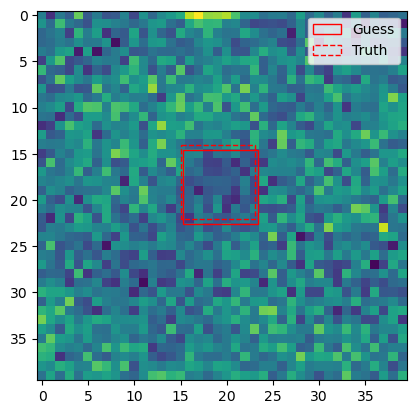

In [30]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.imshow(img[0,...])

colors = ["red", "black", "purple"]

for i in range(len(prediction[0]['boxes'])):
    if prediction[0]['scores'][i]>=0.5:
        xmin, ymin, xmax, ymax = prediction[0]['boxes'][i].cpu().numpy()
        rectangle = plt.Rectangle((xmin,ymin), xmax-xmin,ymax-ymin, fc='none',ec=colors[i], label = 'Guess')
        ax.add_patch(rectangle)
        
for i in range(len(truth['boxes'])):
    xmin, ymin, xmax, ymax = truth['boxes'][i].cpu().numpy()
    rectangle = plt.Rectangle((xmin,ymin), xmax-xmin,ymax-ymin, fc='none',ec=colors[i], linestyle = '--', label = 'Truth')
    ax.add_patch(rectangle)

plt.legend()
plt.savefig('./figs/region_prop_{}.png'.format(j))
plt.savefig('./figs/region_prop_{}.pdf'.format(j))

plt.show()
plt.close()

In [ ]:
_

In [ ]:
prediction[0]['boxes'][0,0]

# WISE

In [19]:

root = '/project/r/rbond/jorlo/datasets/act_centered_wise_stamps/'
len(list(sorted(os.listdir(os.path.join(root, "masks")))))

2103

In [20]:
# use our dataset and defined transformations
dataset = WiseDataset(root, get_transform(train=True))
dataset_test = WiseDataset(root, get_transform(train=False))

# split the dataset in train and test set
torch.manual_seed(1)
indices = torch.randperm(len(dataset)).tolist()
dataset = torch.utils.data.Subset(dataset, indices[:-50])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-50:])

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=2, shuffle=True, num_workers=4,
    collate_fn=visionutils.utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=1, shuffle=False, num_workers=4,
    collate_fn=visionutils.utils.collate_fn)

In [21]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# our dataset has two classes only - background and person
num_classes = 2

# get the model using our helper function
model = get_instance_frcnn_model(num_classes)
# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)

# and a learning rate scheduler which decreases the learning rate by
# 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

In [22]:
# let's train it for 10 epochs
from torch.optim.lr_scheduler import StepLR
num_epochs = 10

#model.load_state_dict(torch.load("/project/r/rbond/jorlo/ml-clusters/models/torch-act/wise-mobilenet-frcnn.pth"))

for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, data_loader_test, device=device)
    torch.save(model.state_dict(), "/project/r/rbond/jorlo/ml-clusters/models/torch-act/wise-mobilenet-frcnn.pth")


Epoch: [0]  [   0/1026]  eta: 0:38:18  lr: 0.000010  loss: 1.4332 (1.4332)  loss_classifier: 0.6880 (0.6880)  loss_box_reg: 0.0382 (0.0382)  loss_objectness: 0.6947 (0.6947)  loss_rpn_box_reg: 0.0123 (0.0123)  time: 2.2400  data: 0.1082  max mem: 3325
Epoch: [0]  [  10/1026]  eta: 0:05:30  lr: 0.000060  loss: 1.4028 (1.4082)  loss_classifier: 0.6876 (0.6861)  loss_box_reg: 0.0227 (0.0235)  loss_objectness: 0.6920 (0.6919)  loss_rpn_box_reg: 0.0069 (0.0067)  time: 0.3250  data: 0.0214  max mem: 3953
Epoch: [0]  [  20/1026]  eta: 0:03:51  lr: 0.000110  loss: 1.3883 (1.3868)  loss_classifier: 0.6705 (0.6677)  loss_box_reg: 0.0211 (0.0220)  loss_objectness: 0.6904 (0.6902)  loss_rpn_box_reg: 0.0064 (0.0070)  time: 0.1292  data: 0.0089  max mem: 3953
Epoch: [0]  [  30/1026]  eta: 0:03:15  lr: 0.000160  loss: 1.3302 (1.3538)  loss_classifier: 0.6110 (0.6365)  loss_box_reg: 0.0219 (0.0246)  loss_objectness: 0.6839 (0.6857)  loss_rpn_box_reg: 0.0064 (0.0070)  time: 0.1247  data: 0.0051  max me

Epoch: [0]  [ 330/1026]  eta: 0:01:31  lr: 0.001658  loss: 0.2926 (0.5911)  loss_classifier: 0.1196 (0.2137)  loss_box_reg: 0.0794 (0.0615)  loss_objectness: 0.0866 (0.3115)  loss_rpn_box_reg: 0.0039 (0.0044)  time: 0.1241  data: 0.0056  max mem: 3953
Epoch: [0]  [ 340/1026]  eta: 0:01:29  lr: 0.001708  loss: 0.2689 (0.5818)  loss_classifier: 0.1126 (0.2108)  loss_box_reg: 0.0710 (0.0619)  loss_objectness: 0.0777 (0.3047)  loss_rpn_box_reg: 0.0039 (0.0044)  time: 0.1240  data: 0.0056  max mem: 3953
Epoch: [0]  [ 350/1026]  eta: 0:01:28  lr: 0.001758  loss: 0.2858 (0.5735)  loss_classifier: 0.1256 (0.2084)  loss_box_reg: 0.0862 (0.0626)  loss_objectness: 0.0735 (0.2981)  loss_rpn_box_reg: 0.0034 (0.0044)  time: 0.1239  data: 0.0056  max mem: 3953
Epoch: [0]  [ 360/1026]  eta: 0:01:26  lr: 0.001808  loss: 0.2777 (0.5653)  loss_classifier: 0.1239 (0.2059)  loss_box_reg: 0.0871 (0.0632)  loss_objectness: 0.0735 (0.2919)  loss_rpn_box_reg: 0.0035 (0.0044)  time: 0.1239  data: 0.0056  max me

Epoch: [0]  [ 660/1026]  eta: 0:00:46  lr: 0.003307  loss: 0.2006 (0.4157)  loss_classifier: 0.0778 (0.1583)  loss_box_reg: 0.0820 (0.0731)  loss_objectness: 0.0306 (0.1806)  loss_rpn_box_reg: 0.0030 (0.0038)  time: 0.1242  data: 0.0057  max mem: 3953
Epoch: [0]  [ 670/1026]  eta: 0:00:45  lr: 0.003357  loss: 0.1796 (0.4123)  loss_classifier: 0.0730 (0.1571)  loss_box_reg: 0.0727 (0.0731)  loss_objectness: 0.0286 (0.1783)  loss_rpn_box_reg: 0.0029 (0.0038)  time: 0.1242  data: 0.0056  max mem: 3953
Epoch: [0]  [ 680/1026]  eta: 0:00:44  lr: 0.003407  loss: 0.1895 (0.4092)  loss_classifier: 0.0754 (0.1560)  loss_box_reg: 0.0794 (0.0732)  loss_objectness: 0.0293 (0.1762)  loss_rpn_box_reg: 0.0029 (0.0038)  time: 0.1242  data: 0.0057  max mem: 3953
Epoch: [0]  [ 690/1026]  eta: 0:00:42  lr: 0.003457  loss: 0.2001 (0.4063)  loss_classifier: 0.0816 (0.1550)  loss_box_reg: 0.0850 (0.0735)  loss_objectness: 0.0296 (0.1740)  loss_rpn_box_reg: 0.0023 (0.0038)  time: 0.1242  data: 0.0057  max me

Epoch: [0]  [ 990/1026]  eta: 0:00:04  lr: 0.004955  loss: 0.1401 (0.3358)  loss_classifier: 0.0568 (0.1298)  loss_box_reg: 0.0640 (0.0740)  loss_objectness: 0.0203 (0.1287)  loss_rpn_box_reg: 0.0019 (0.0033)  time: 0.1248  data: 0.0055  max mem: 3953
Epoch: [0]  [1000/1026]  eta: 0:00:03  lr: 0.005000  loss: 0.1476 (0.3340)  loss_classifier: 0.0617 (0.1291)  loss_box_reg: 0.0657 (0.0740)  loss_objectness: 0.0183 (0.1276)  loss_rpn_box_reg: 0.0018 (0.0033)  time: 0.1248  data: 0.0056  max mem: 3953
Epoch: [0]  [1010/1026]  eta: 0:00:02  lr: 0.005000  loss: 0.1538 (0.3324)  loss_classifier: 0.0617 (0.1285)  loss_box_reg: 0.0696 (0.0741)  loss_objectness: 0.0173 (0.1265)  loss_rpn_box_reg: 0.0018 (0.0033)  time: 0.2196  data: 0.0056  max mem: 3953
Epoch: [0]  [1020/1026]  eta: 0:00:00  lr: 0.005000  loss: 0.1697 (0.3309)  loss_classifier: 0.0688 (0.1280)  loss_box_reg: 0.0865 (0.0742)  loss_objectness: 0.0146 (0.1254)  loss_rpn_box_reg: 0.0018 (0.0033)  time: 0.3334  data: 0.0057  max me

Epoch: [1]  [ 220/1026]  eta: 0:04:43  lr: 0.005000  loss: 0.1300 (0.1388)  loss_classifier: 0.0427 (0.0498)  loss_box_reg: 0.0739 (0.0697)  loss_objectness: 0.0134 (0.0172)  loss_rpn_box_reg: 0.0019 (0.0021)  time: 0.3495  data: 0.0056  max mem: 3953
Epoch: [1]  [ 230/1026]  eta: 0:04:40  lr: 0.005000  loss: 0.1238 (0.1384)  loss_classifier: 0.0425 (0.0496)  loss_box_reg: 0.0712 (0.0697)  loss_objectness: 0.0133 (0.0171)  loss_rpn_box_reg: 0.0021 (0.0021)  time: 0.3458  data: 0.0062  max mem: 3953
Epoch: [1]  [ 240/1026]  eta: 0:04:36  lr: 0.005000  loss: 0.1265 (0.1380)  loss_classifier: 0.0425 (0.0493)  loss_box_reg: 0.0653 (0.0696)  loss_objectness: 0.0136 (0.0171)  loss_rpn_box_reg: 0.0020 (0.0021)  time: 0.3540  data: 0.0063  max mem: 3953
Epoch: [1]  [ 250/1026]  eta: 0:04:33  lr: 0.005000  loss: 0.1124 (0.1371)  loss_classifier: 0.0332 (0.0487)  loss_box_reg: 0.0653 (0.0694)  loss_objectness: 0.0136 (0.0169)  loss_rpn_box_reg: 0.0027 (0.0021)  time: 0.3575  data: 0.0062  max me

Epoch: [1]  [ 550/1026]  eta: 0:02:48  lr: 0.005000  loss: 0.0552 (0.1054)  loss_classifier: 0.0127 (0.0344)  loss_box_reg: 0.0324 (0.0550)  loss_objectness: 0.0083 (0.0138)  loss_rpn_box_reg: 0.0019 (0.0021)  time: 0.3527  data: 0.0052  max mem: 3953
Epoch: [1]  [ 560/1026]  eta: 0:02:44  lr: 0.005000  loss: 0.0575 (0.1050)  loss_classifier: 0.0134 (0.0344)  loss_box_reg: 0.0327 (0.0547)  loss_objectness: 0.0083 (0.0138)  loss_rpn_box_reg: 0.0019 (0.0021)  time: 0.3519  data: 0.0053  max mem: 3953
Epoch: [1]  [ 570/1026]  eta: 0:02:41  lr: 0.005000  loss: 0.0616 (0.1041)  loss_classifier: 0.0189 (0.0341)  loss_box_reg: 0.0336 (0.0543)  loss_objectness: 0.0069 (0.0137)  loss_rpn_box_reg: 0.0017 (0.0021)  time: 0.3551  data: 0.0053  max mem: 3953
Epoch: [1]  [ 580/1026]  eta: 0:02:37  lr: 0.005000  loss: 0.0572 (0.1033)  loss_classifier: 0.0159 (0.0338)  loss_box_reg: 0.0309 (0.0539)  loss_objectness: 0.0076 (0.0136)  loss_rpn_box_reg: 0.0015 (0.0021)  time: 0.3467  data: 0.0052  max me

Epoch: [1]  [ 880/1026]  eta: 0:00:51  lr: 0.005000  loss: 0.0488 (0.0858)  loss_classifier: 0.0139 (0.0280)  loss_box_reg: 0.0282 (0.0446)  loss_objectness: 0.0033 (0.0114)  loss_rpn_box_reg: 0.0014 (0.0018)  time: 0.3523  data: 0.0052  max mem: 3953
Epoch: [1]  [ 890/1026]  eta: 0:00:47  lr: 0.005000  loss: 0.0481 (0.0854)  loss_classifier: 0.0137 (0.0278)  loss_box_reg: 0.0268 (0.0443)  loss_objectness: 0.0042 (0.0114)  loss_rpn_box_reg: 0.0011 (0.0018)  time: 0.3519  data: 0.0052  max mem: 3953
Epoch: [1]  [ 900/1026]  eta: 0:00:44  lr: 0.005000  loss: 0.0434 (0.0849)  loss_classifier: 0.0111 (0.0276)  loss_box_reg: 0.0245 (0.0441)  loss_objectness: 0.0040 (0.0113)  loss_rpn_box_reg: 0.0011 (0.0018)  time: 0.3507  data: 0.0055  max mem: 3953
Epoch: [1]  [ 910/1026]  eta: 0:00:40  lr: 0.005000  loss: 0.0453 (0.0845)  loss_classifier: 0.0120 (0.0275)  loss_box_reg: 0.0243 (0.0439)  loss_objectness: 0.0065 (0.0113)  loss_rpn_box_reg: 0.0011 (0.0018)  time: 0.3553  data: 0.0056  max me

Epoch: [2]  [ 110/1026]  eta: 0:05:20  lr: 0.005000  loss: 0.0441 (0.0516)  loss_classifier: 0.0153 (0.0167)  loss_box_reg: 0.0243 (0.0280)  loss_objectness: 0.0026 (0.0057)  loss_rpn_box_reg: 0.0010 (0.0012)  time: 0.3539  data: 0.0052  max mem: 3953
Epoch: [2]  [ 120/1026]  eta: 0:05:17  lr: 0.005000  loss: 0.0498 (0.0547)  loss_classifier: 0.0171 (0.0183)  loss_box_reg: 0.0254 (0.0288)  loss_objectness: 0.0029 (0.0064)  loss_rpn_box_reg: 0.0010 (0.0012)  time: 0.3533  data: 0.0051  max mem: 3953
Epoch: [2]  [ 130/1026]  eta: 0:05:14  lr: 0.005000  loss: 0.0618 (0.0564)  loss_classifier: 0.0194 (0.0190)  loss_box_reg: 0.0312 (0.0292)  loss_objectness: 0.0077 (0.0070)  loss_rpn_box_reg: 0.0011 (0.0012)  time: 0.3548  data: 0.0051  max mem: 3953
Epoch: [2]  [ 140/1026]  eta: 0:05:10  lr: 0.005000  loss: 0.0569 (0.0563)  loss_classifier: 0.0172 (0.0190)  loss_box_reg: 0.0312 (0.0293)  loss_objectness: 0.0056 (0.0068)  loss_rpn_box_reg: 0.0012 (0.0012)  time: 0.3546  data: 0.0052  max me

Epoch: [2]  [ 440/1026]  eta: 0:03:25  lr: 0.005000  loss: 0.0456 (0.0509)  loss_classifier: 0.0175 (0.0169)  loss_box_reg: 0.0250 (0.0267)  loss_objectness: 0.0060 (0.0062)  loss_rpn_box_reg: 0.0008 (0.0012)  time: 0.3499  data: 0.0054  max mem: 3953
Epoch: [2]  [ 450/1026]  eta: 0:03:22  lr: 0.005000  loss: 0.0425 (0.0508)  loss_classifier: 0.0159 (0.0168)  loss_box_reg: 0.0235 (0.0266)  loss_objectness: 0.0065 (0.0061)  loss_rpn_box_reg: 0.0008 (0.0012)  time: 0.3485  data: 0.0052  max mem: 3953
Epoch: [2]  [ 460/1026]  eta: 0:03:18  lr: 0.005000  loss: 0.0478 (0.0511)  loss_classifier: 0.0136 (0.0169)  loss_box_reg: 0.0256 (0.0268)  loss_objectness: 0.0062 (0.0062)  loss_rpn_box_reg: 0.0008 (0.0012)  time: 0.3527  data: 0.0053  max mem: 3953
Epoch: [2]  [ 470/1026]  eta: 0:03:15  lr: 0.005000  loss: 0.0549 (0.0512)  loss_classifier: 0.0185 (0.0169)  loss_box_reg: 0.0308 (0.0270)  loss_objectness: 0.0023 (0.0061)  loss_rpn_box_reg: 0.0008 (0.0012)  time: 0.3542  data: 0.0055  max me

Epoch: [2]  [ 770/1026]  eta: 0:01:29  lr: 0.005000  loss: 0.0549 (0.0553)  loss_classifier: 0.0157 (0.0183)  loss_box_reg: 0.0309 (0.0299)  loss_objectness: 0.0041 (0.0059)  loss_rpn_box_reg: 0.0012 (0.0011)  time: 0.3568  data: 0.0056  max mem: 3953
Epoch: [2]  [ 780/1026]  eta: 0:01:26  lr: 0.005000  loss: 0.0538 (0.0553)  loss_classifier: 0.0168 (0.0184)  loss_box_reg: 0.0309 (0.0299)  loss_objectness: 0.0027 (0.0059)  loss_rpn_box_reg: 0.0010 (0.0011)  time: 0.3581  data: 0.0058  max mem: 3953
Epoch: [2]  [ 790/1026]  eta: 0:01:22  lr: 0.005000  loss: 0.0521 (0.0552)  loss_classifier: 0.0133 (0.0183)  loss_box_reg: 0.0257 (0.0299)  loss_objectness: 0.0055 (0.0059)  loss_rpn_box_reg: 0.0010 (0.0011)  time: 0.3555  data: 0.0058  max mem: 3953
Epoch: [2]  [ 800/1026]  eta: 0:01:19  lr: 0.005000  loss: 0.0436 (0.0551)  loss_classifier: 0.0115 (0.0182)  loss_box_reg: 0.0255 (0.0299)  loss_objectness: 0.0032 (0.0059)  loss_rpn_box_reg: 0.0011 (0.0011)  time: 0.3426  data: 0.0057  max me

Epoch: [3]  [   0/1026]  eta: 0:08:37  lr: 0.000500  loss: 0.0420 (0.0420)  loss_classifier: 0.0120 (0.0120)  loss_box_reg: 0.0233 (0.0233)  loss_objectness: 0.0059 (0.0059)  loss_rpn_box_reg: 0.0008 (0.0008)  time: 0.5047  data: 0.1391  max mem: 3953
Epoch: [3]  [  10/1026]  eta: 0:06:09  lr: 0.000500  loss: 0.0405 (0.0422)  loss_classifier: 0.0107 (0.0114)  loss_box_reg: 0.0215 (0.0236)  loss_objectness: 0.0059 (0.0063)  loss_rpn_box_reg: 0.0009 (0.0009)  time: 0.3634  data: 0.0175  max mem: 3953
Epoch: [3]  [  20/1026]  eta: 0:05:54  lr: 0.000500  loss: 0.0368 (0.0410)  loss_classifier: 0.0098 (0.0109)  loss_box_reg: 0.0208 (0.0235)  loss_objectness: 0.0047 (0.0058)  loss_rpn_box_reg: 0.0009 (0.0008)  time: 0.3451  data: 0.0052  max mem: 3953
Epoch: [3]  [  30/1026]  eta: 0:05:51  lr: 0.000500  loss: 0.0356 (0.0391)  loss_classifier: 0.0088 (0.0103)  loss_box_reg: 0.0196 (0.0224)  loss_objectness: 0.0030 (0.0056)  loss_rpn_box_reg: 0.0007 (0.0008)  time: 0.3474  data: 0.0051  max me

Epoch: [3]  [ 330/1026]  eta: 0:04:05  lr: 0.000500  loss: 0.0379 (0.0416)  loss_classifier: 0.0092 (0.0113)  loss_box_reg: 0.0239 (0.0242)  loss_objectness: 0.0060 (0.0053)  loss_rpn_box_reg: 0.0006 (0.0007)  time: 0.3544  data: 0.0057  max mem: 3953
Epoch: [3]  [ 340/1026]  eta: 0:04:01  lr: 0.000500  loss: 0.0355 (0.0413)  loss_classifier: 0.0076 (0.0113)  loss_box_reg: 0.0229 (0.0241)  loss_objectness: 0.0020 (0.0053)  loss_rpn_box_reg: 0.0007 (0.0007)  time: 0.3563  data: 0.0061  max mem: 3953
Epoch: [3]  [ 350/1026]  eta: 0:03:58  lr: 0.000500  loss: 0.0312 (0.0411)  loss_classifier: 0.0076 (0.0112)  loss_box_reg: 0.0154 (0.0239)  loss_objectness: 0.0063 (0.0054)  loss_rpn_box_reg: 0.0006 (0.0007)  time: 0.3578  data: 0.0060  max mem: 3953
Epoch: [3]  [ 360/1026]  eta: 0:03:54  lr: 0.000500  loss: 0.0341 (0.0411)  loss_classifier: 0.0084 (0.0112)  loss_box_reg: 0.0213 (0.0238)  loss_objectness: 0.0065 (0.0054)  loss_rpn_box_reg: 0.0006 (0.0007)  time: 0.3578  data: 0.0058  max me

Epoch: [3]  [ 660/1026]  eta: 0:02:09  lr: 0.000500  loss: 0.0370 (0.0398)  loss_classifier: 0.0082 (0.0104)  loss_box_reg: 0.0226 (0.0233)  loss_objectness: 0.0028 (0.0053)  loss_rpn_box_reg: 0.0006 (0.0007)  time: 0.3479  data: 0.0055  max mem: 3953
Epoch: [3]  [ 670/1026]  eta: 0:02:05  lr: 0.000500  loss: 0.0359 (0.0397)  loss_classifier: 0.0085 (0.0104)  loss_box_reg: 0.0215 (0.0233)  loss_objectness: 0.0060 (0.0053)  loss_rpn_box_reg: 0.0006 (0.0007)  time: 0.3493  data: 0.0055  max mem: 3953
Epoch: [3]  [ 680/1026]  eta: 0:02:02  lr: 0.000500  loss: 0.0359 (0.0397)  loss_classifier: 0.0082 (0.0104)  loss_box_reg: 0.0204 (0.0233)  loss_objectness: 0.0060 (0.0053)  loss_rpn_box_reg: 0.0006 (0.0007)  time: 0.3573  data: 0.0059  max mem: 3953
Epoch: [3]  [ 690/1026]  eta: 0:01:58  lr: 0.000500  loss: 0.0359 (0.0397)  loss_classifier: 0.0095 (0.0104)  loss_box_reg: 0.0213 (0.0233)  loss_objectness: 0.0055 (0.0053)  loss_rpn_box_reg: 0.0006 (0.0007)  time: 0.3570  data: 0.0061  max me

Epoch: [3]  [ 990/1026]  eta: 0:00:12  lr: 0.000500  loss: 0.0314 (0.0377)  loss_classifier: 0.0076 (0.0096)  loss_box_reg: 0.0165 (0.0222)  loss_objectness: 0.0052 (0.0052)  loss_rpn_box_reg: 0.0006 (0.0007)  time: 0.1254  data: 0.0051  max mem: 3953
Epoch: [3]  [1000/1026]  eta: 0:00:08  lr: 0.000500  loss: 0.0305 (0.0376)  loss_classifier: 0.0076 (0.0096)  loss_box_reg: 0.0180 (0.0222)  loss_objectness: 0.0015 (0.0052)  loss_rpn_box_reg: 0.0006 (0.0007)  time: 0.1254  data: 0.0051  max mem: 3953
Epoch: [3]  [1010/1026]  eta: 0:00:05  lr: 0.000500  loss: 0.0319 (0.0376)  loss_classifier: 0.0075 (0.0096)  loss_box_reg: 0.0180 (0.0222)  loss_objectness: 0.0017 (0.0052)  loss_rpn_box_reg: 0.0006 (0.0007)  time: 0.1256  data: 0.0052  max mem: 3953
Epoch: [3]  [1020/1026]  eta: 0:00:02  lr: 0.000500  loss: 0.0328 (0.0375)  loss_classifier: 0.0078 (0.0096)  loss_box_reg: 0.0164 (0.0222)  loss_objectness: 0.0059 (0.0052)  loss_rpn_box_reg: 0.0006 (0.0007)  time: 0.1253  data: 0.0052  max me

Epoch: [4]  [ 220/1026]  eta: 0:01:41  lr: 0.000500  loss: 0.0295 (0.0352)  loss_classifier: 0.0075 (0.0085)  loss_box_reg: 0.0151 (0.0205)  loss_objectness: 0.0022 (0.0055)  loss_rpn_box_reg: 0.0007 (0.0007)  time: 0.1245  data: 0.0051  max mem: 3953
Epoch: [4]  [ 230/1026]  eta: 0:01:39  lr: 0.000500  loss: 0.0290 (0.0352)  loss_classifier: 0.0073 (0.0085)  loss_box_reg: 0.0206 (0.0206)  loss_objectness: 0.0016 (0.0054)  loss_rpn_box_reg: 0.0007 (0.0007)  time: 0.1245  data: 0.0051  max mem: 3953
Epoch: [4]  [ 240/1026]  eta: 0:01:38  lr: 0.000500  loss: 0.0315 (0.0352)  loss_classifier: 0.0065 (0.0084)  loss_box_reg: 0.0206 (0.0206)  loss_objectness: 0.0018 (0.0055)  loss_rpn_box_reg: 0.0006 (0.0007)  time: 0.1247  data: 0.0052  max mem: 3953
Epoch: [4]  [ 250/1026]  eta: 0:01:37  lr: 0.000500  loss: 0.0323 (0.0350)  loss_classifier: 0.0066 (0.0083)  loss_box_reg: 0.0179 (0.0206)  loss_objectness: 0.0019 (0.0054)  loss_rpn_box_reg: 0.0006 (0.0007)  time: 0.1247  data: 0.0052  max me

Epoch: [4]  [ 550/1026]  eta: 0:01:00  lr: 0.000500  loss: 0.0284 (0.0336)  loss_classifier: 0.0065 (0.0080)  loss_box_reg: 0.0131 (0.0199)  loss_objectness: 0.0062 (0.0051)  loss_rpn_box_reg: 0.0006 (0.0006)  time: 0.1245  data: 0.0051  max mem: 3953
Epoch: [4]  [ 560/1026]  eta: 0:00:59  lr: 0.000500  loss: 0.0280 (0.0336)  loss_classifier: 0.0065 (0.0079)  loss_box_reg: 0.0137 (0.0198)  loss_objectness: 0.0062 (0.0052)  loss_rpn_box_reg: 0.0006 (0.0006)  time: 0.1246  data: 0.0052  max mem: 3953
Epoch: [4]  [ 570/1026]  eta: 0:00:57  lr: 0.000500  loss: 0.0269 (0.0334)  loss_classifier: 0.0054 (0.0079)  loss_box_reg: 0.0135 (0.0197)  loss_objectness: 0.0059 (0.0052)  loss_rpn_box_reg: 0.0006 (0.0006)  time: 0.1246  data: 0.0051  max mem: 3953
Epoch: [4]  [ 580/1026]  eta: 0:00:56  lr: 0.000500  loss: 0.0238 (0.0333)  loss_classifier: 0.0055 (0.0079)  loss_box_reg: 0.0136 (0.0196)  loss_objectness: 0.0023 (0.0052)  loss_rpn_box_reg: 0.0006 (0.0006)  time: 0.1246  data: 0.0051  max me

Epoch: [4]  [ 880/1026]  eta: 0:00:18  lr: 0.000500  loss: 0.0278 (0.0331)  loss_classifier: 0.0078 (0.0079)  loss_box_reg: 0.0147 (0.0194)  loss_objectness: 0.0056 (0.0052)  loss_rpn_box_reg: 0.0006 (0.0006)  time: 0.1335  data: 0.0063  max mem: 3953
Epoch: [4]  [ 890/1026]  eta: 0:00:17  lr: 0.000500  loss: 0.0274 (0.0331)  loss_classifier: 0.0065 (0.0078)  loss_box_reg: 0.0153 (0.0194)  loss_objectness: 0.0017 (0.0052)  loss_rpn_box_reg: 0.0006 (0.0006)  time: 0.1338  data: 0.0062  max mem: 3953
Epoch: [4]  [ 900/1026]  eta: 0:00:16  lr: 0.000500  loss: 0.0279 (0.0331)  loss_classifier: 0.0065 (0.0079)  loss_box_reg: 0.0186 (0.0194)  loss_objectness: 0.0017 (0.0052)  loss_rpn_box_reg: 0.0006 (0.0006)  time: 0.1318  data: 0.0059  max mem: 3953
Epoch: [4]  [ 910/1026]  eta: 0:00:14  lr: 0.000500  loss: 0.0346 (0.0332)  loss_classifier: 0.0078 (0.0079)  loss_box_reg: 0.0199 (0.0195)  loss_objectness: 0.0019 (0.0051)  loss_rpn_box_reg: 0.0006 (0.0006)  time: 0.1294  data: 0.0058  max me

Epoch: [5]  [ 110/1026]  eta: 0:01:56  lr: 0.000500  loss: 0.0268 (0.0342)  loss_classifier: 0.0062 (0.0081)  loss_box_reg: 0.0174 (0.0194)  loss_objectness: 0.0021 (0.0061)  loss_rpn_box_reg: 0.0006 (0.0007)  time: 0.1276  data: 0.0053  max mem: 3953
Epoch: [5]  [ 120/1026]  eta: 0:01:55  lr: 0.000500  loss: 0.0282 (0.0345)  loss_classifier: 0.0064 (0.0080)  loss_box_reg: 0.0196 (0.0195)  loss_objectness: 0.0021 (0.0063)  loss_rpn_box_reg: 0.0006 (0.0007)  time: 0.1287  data: 0.0052  max mem: 3953
Epoch: [5]  [ 130/1026]  eta: 0:01:54  lr: 0.000500  loss: 0.0291 (0.0341)  loss_classifier: 0.0062 (0.0079)  loss_box_reg: 0.0205 (0.0192)  loss_objectness: 0.0047 (0.0063)  loss_rpn_box_reg: 0.0006 (0.0007)  time: 0.1287  data: 0.0052  max mem: 3953
Epoch: [5]  [ 140/1026]  eta: 0:01:53  lr: 0.000500  loss: 0.0276 (0.0350)  loss_classifier: 0.0065 (0.0082)  loss_box_reg: 0.0165 (0.0196)  loss_objectness: 0.0062 (0.0065)  loss_rpn_box_reg: 0.0006 (0.0007)  time: 0.1286  data: 0.0055  max me

Epoch: [5]  [ 440/1026]  eta: 0:01:14  lr: 0.000500  loss: 0.0241 (0.0326)  loss_classifier: 0.0051 (0.0077)  loss_box_reg: 0.0132 (0.0188)  loss_objectness: 0.0046 (0.0054)  loss_rpn_box_reg: 0.0006 (0.0006)  time: 0.1274  data: 0.0051  max mem: 3953
Epoch: [5]  [ 450/1026]  eta: 0:01:12  lr: 0.000500  loss: 0.0229 (0.0325)  loss_classifier: 0.0055 (0.0077)  loss_box_reg: 0.0132 (0.0188)  loss_objectness: 0.0014 (0.0053)  loss_rpn_box_reg: 0.0006 (0.0006)  time: 0.1274  data: 0.0051  max mem: 3953
Epoch: [5]  [ 460/1026]  eta: 0:01:11  lr: 0.000500  loss: 0.0233 (0.0323)  loss_classifier: 0.0055 (0.0076)  loss_box_reg: 0.0143 (0.0187)  loss_objectness: 0.0015 (0.0053)  loss_rpn_box_reg: 0.0006 (0.0006)  time: 0.1273  data: 0.0051  max mem: 3953
Epoch: [5]  [ 470/1026]  eta: 0:01:10  lr: 0.000500  loss: 0.0259 (0.0323)  loss_classifier: 0.0054 (0.0076)  loss_box_reg: 0.0148 (0.0188)  loss_objectness: 0.0015 (0.0052)  loss_rpn_box_reg: 0.0006 (0.0006)  time: 0.1274  data: 0.0051  max me

Epoch: [5]  [ 770/1026]  eta: 0:00:32  lr: 0.000500  loss: 0.0275 (0.0314)  loss_classifier: 0.0055 (0.0072)  loss_box_reg: 0.0150 (0.0185)  loss_objectness: 0.0017 (0.0051)  loss_rpn_box_reg: 0.0006 (0.0006)  time: 0.1249  data: 0.0051  max mem: 3953
Epoch: [5]  [ 780/1026]  eta: 0:00:30  lr: 0.000500  loss: 0.0287 (0.0313)  loss_classifier: 0.0057 (0.0072)  loss_box_reg: 0.0161 (0.0184)  loss_objectness: 0.0046 (0.0051)  loss_rpn_box_reg: 0.0006 (0.0006)  time: 0.1252  data: 0.0052  max mem: 3953
Epoch: [5]  [ 790/1026]  eta: 0:00:29  lr: 0.000500  loss: 0.0244 (0.0313)  loss_classifier: 0.0051 (0.0072)  loss_box_reg: 0.0144 (0.0184)  loss_objectness: 0.0045 (0.0051)  loss_rpn_box_reg: 0.0006 (0.0006)  time: 0.1252  data: 0.0054  max mem: 3953
Epoch: [5]  [ 800/1026]  eta: 0:00:28  lr: 0.000500  loss: 0.0244 (0.0312)  loss_classifier: 0.0061 (0.0072)  loss_box_reg: 0.0144 (0.0184)  loss_objectness: 0.0022 (0.0051)  loss_rpn_box_reg: 0.0006 (0.0006)  time: 0.1248  data: 0.0055  max me

Epoch: [6]  [   0/1026]  eta: 0:04:29  lr: 0.000050  loss: 0.0256 (0.0256)  loss_classifier: 0.0035 (0.0035)  loss_box_reg: 0.0188 (0.0188)  loss_objectness: 0.0027 (0.0027)  loss_rpn_box_reg: 0.0006 (0.0006)  time: 0.2626  data: 0.1278  max mem: 3953
Epoch: [6]  [  10/1026]  eta: 0:02:23  lr: 0.000050  loss: 0.0241 (0.0243)  loss_classifier: 0.0052 (0.0053)  loss_box_reg: 0.0155 (0.0147)  loss_objectness: 0.0018 (0.0037)  loss_rpn_box_reg: 0.0006 (0.0006)  time: 0.1411  data: 0.0196  max mem: 3953
Epoch: [6]  [  20/1026]  eta: 0:02:14  lr: 0.000050  loss: 0.0241 (0.0264)  loss_classifier: 0.0052 (0.0058)  loss_box_reg: 0.0149 (0.0161)  loss_objectness: 0.0018 (0.0040)  loss_rpn_box_reg: 0.0006 (0.0006)  time: 0.1269  data: 0.0070  max mem: 3953
Epoch: [6]  [  30/1026]  eta: 0:02:10  lr: 0.000050  loss: 0.0256 (0.0264)  loss_classifier: 0.0052 (0.0058)  loss_box_reg: 0.0148 (0.0162)  loss_objectness: 0.0019 (0.0038)  loss_rpn_box_reg: 0.0006 (0.0006)  time: 0.1249  data: 0.0051  max me

Epoch: [6]  [ 330/1026]  eta: 0:01:27  lr: 0.000050  loss: 0.0218 (0.0292)  loss_classifier: 0.0052 (0.0066)  loss_box_reg: 0.0112 (0.0170)  loss_objectness: 0.0016 (0.0050)  loss_rpn_box_reg: 0.0006 (0.0006)  time: 0.1239  data: 0.0056  max mem: 3953
Epoch: [6]  [ 340/1026]  eta: 0:01:25  lr: 0.000050  loss: 0.0222 (0.0292)  loss_classifier: 0.0052 (0.0066)  loss_box_reg: 0.0118 (0.0170)  loss_objectness: 0.0016 (0.0050)  loss_rpn_box_reg: 0.0006 (0.0006)  time: 0.1240  data: 0.0055  max mem: 3953
Epoch: [6]  [ 350/1026]  eta: 0:01:24  lr: 0.000050  loss: 0.0256 (0.0291)  loss_classifier: 0.0058 (0.0066)  loss_box_reg: 0.0152 (0.0170)  loss_objectness: 0.0016 (0.0049)  loss_rpn_box_reg: 0.0006 (0.0006)  time: 0.1242  data: 0.0055  max mem: 3953
Epoch: [6]  [ 360/1026]  eta: 0:01:23  lr: 0.000050  loss: 0.0272 (0.0293)  loss_classifier: 0.0060 (0.0066)  loss_box_reg: 0.0158 (0.0172)  loss_objectness: 0.0016 (0.0049)  loss_rpn_box_reg: 0.0006 (0.0006)  time: 0.1242  data: 0.0056  max me

Epoch: [6]  [ 660/1026]  eta: 0:00:45  lr: 0.000050  loss: 0.0247 (0.0293)  loss_classifier: 0.0053 (0.0068)  loss_box_reg: 0.0143 (0.0169)  loss_objectness: 0.0062 (0.0050)  loss_rpn_box_reg: 0.0006 (0.0006)  time: 0.1237  data: 0.0055  max mem: 3953
Epoch: [6]  [ 670/1026]  eta: 0:00:44  lr: 0.000050  loss: 0.0238 (0.0292)  loss_classifier: 0.0051 (0.0068)  loss_box_reg: 0.0116 (0.0169)  loss_objectness: 0.0057 (0.0050)  loss_rpn_box_reg: 0.0006 (0.0006)  time: 0.1236  data: 0.0054  max mem: 3953
Epoch: [6]  [ 680/1026]  eta: 0:00:43  lr: 0.000050  loss: 0.0252 (0.0292)  loss_classifier: 0.0046 (0.0068)  loss_box_reg: 0.0135 (0.0169)  loss_objectness: 0.0017 (0.0049)  loss_rpn_box_reg: 0.0006 (0.0006)  time: 0.1234  data: 0.0054  max mem: 3953
Epoch: [6]  [ 690/1026]  eta: 0:00:41  lr: 0.000050  loss: 0.0276 (0.0292)  loss_classifier: 0.0050 (0.0068)  loss_box_reg: 0.0148 (0.0169)  loss_objectness: 0.0020 (0.0049)  loss_rpn_box_reg: 0.0006 (0.0006)  time: 0.1234  data: 0.0055  max me

Epoch: [6]  [ 990/1026]  eta: 0:00:04  lr: 0.000050  loss: 0.0258 (0.0293)  loss_classifier: 0.0051 (0.0068)  loss_box_reg: 0.0155 (0.0169)  loss_objectness: 0.0019 (0.0049)  loss_rpn_box_reg: 0.0006 (0.0006)  time: 0.1234  data: 0.0054  max mem: 3953
Epoch: [6]  [1000/1026]  eta: 0:00:03  lr: 0.000050  loss: 0.0253 (0.0292)  loss_classifier: 0.0046 (0.0068)  loss_box_reg: 0.0161 (0.0169)  loss_objectness: 0.0015 (0.0049)  loss_rpn_box_reg: 0.0006 (0.0006)  time: 0.1234  data: 0.0054  max mem: 3953
Epoch: [6]  [1010/1026]  eta: 0:00:01  lr: 0.000050  loss: 0.0234 (0.0292)  loss_classifier: 0.0052 (0.0068)  loss_box_reg: 0.0150 (0.0169)  loss_objectness: 0.0015 (0.0049)  loss_rpn_box_reg: 0.0006 (0.0006)  time: 0.1235  data: 0.0055  max mem: 3953
Epoch: [6]  [1020/1026]  eta: 0:00:00  lr: 0.000050  loss: 0.0243 (0.0292)  loss_classifier: 0.0056 (0.0068)  loss_box_reg: 0.0141 (0.0169)  loss_objectness: 0.0020 (0.0049)  loss_rpn_box_reg: 0.0006 (0.0006)  time: 0.1238  data: 0.0055  max me

Epoch: [7]  [ 220/1026]  eta: 0:01:41  lr: 0.000050  loss: 0.0334 (0.0297)  loss_classifier: 0.0060 (0.0066)  loss_box_reg: 0.0202 (0.0171)  loss_objectness: 0.0057 (0.0054)  loss_rpn_box_reg: 0.0006 (0.0006)  time: 0.1243  data: 0.0053  max mem: 3953
Epoch: [7]  [ 230/1026]  eta: 0:01:39  lr: 0.000050  loss: 0.0282 (0.0296)  loss_classifier: 0.0048 (0.0066)  loss_box_reg: 0.0142 (0.0170)  loss_objectness: 0.0065 (0.0055)  loss_rpn_box_reg: 0.0006 (0.0006)  time: 0.1247  data: 0.0056  max mem: 3953
Epoch: [7]  [ 240/1026]  eta: 0:01:38  lr: 0.000050  loss: 0.0251 (0.0295)  loss_classifier: 0.0056 (0.0065)  loss_box_reg: 0.0129 (0.0169)  loss_objectness: 0.0046 (0.0054)  loss_rpn_box_reg: 0.0006 (0.0006)  time: 0.1248  data: 0.0057  max mem: 3953
Epoch: [7]  [ 250/1026]  eta: 0:01:37  lr: 0.000050  loss: 0.0245 (0.0295)  loss_classifier: 0.0056 (0.0065)  loss_box_reg: 0.0129 (0.0170)  loss_objectness: 0.0018 (0.0053)  loss_rpn_box_reg: 0.0006 (0.0006)  time: 0.1247  data: 0.0057  max me

Epoch: [7]  [ 550/1026]  eta: 0:00:59  lr: 0.000050  loss: 0.0258 (0.0288)  loss_classifier: 0.0055 (0.0064)  loss_box_reg: 0.0150 (0.0168)  loss_objectness: 0.0015 (0.0050)  loss_rpn_box_reg: 0.0006 (0.0006)  time: 0.1244  data: 0.0055  max mem: 3953
Epoch: [7]  [ 560/1026]  eta: 0:00:58  lr: 0.000050  loss: 0.0269 (0.0288)  loss_classifier: 0.0062 (0.0064)  loss_box_reg: 0.0189 (0.0168)  loss_objectness: 0.0015 (0.0049)  loss_rpn_box_reg: 0.0006 (0.0006)  time: 0.1245  data: 0.0056  max mem: 3953
Epoch: [7]  [ 570/1026]  eta: 0:00:56  lr: 0.000050  loss: 0.0257 (0.0287)  loss_classifier: 0.0063 (0.0064)  loss_box_reg: 0.0144 (0.0168)  loss_objectness: 0.0017 (0.0049)  loss_rpn_box_reg: 0.0006 (0.0006)  time: 0.1246  data: 0.0056  max mem: 3953
Epoch: [7]  [ 580/1026]  eta: 0:00:55  lr: 0.000050  loss: 0.0236 (0.0287)  loss_classifier: 0.0049 (0.0063)  loss_box_reg: 0.0143 (0.0168)  loss_objectness: 0.0019 (0.0049)  loss_rpn_box_reg: 0.0006 (0.0006)  time: 0.1245  data: 0.0055  max me

Epoch: [7]  [ 880/1026]  eta: 0:00:18  lr: 0.000050  loss: 0.0261 (0.0294)  loss_classifier: 0.0049 (0.0066)  loss_box_reg: 0.0149 (0.0172)  loss_objectness: 0.0052 (0.0050)  loss_rpn_box_reg: 0.0006 (0.0006)  time: 0.1246  data: 0.0056  max mem: 3953
Epoch: [7]  [ 890/1026]  eta: 0:00:16  lr: 0.000050  loss: 0.0239 (0.0294)  loss_classifier: 0.0048 (0.0066)  loss_box_reg: 0.0136 (0.0172)  loss_objectness: 0.0017 (0.0050)  loss_rpn_box_reg: 0.0006 (0.0006)  time: 0.1245  data: 0.0056  max mem: 3953
Epoch: [7]  [ 900/1026]  eta: 0:00:15  lr: 0.000050  loss: 0.0228 (0.0293)  loss_classifier: 0.0042 (0.0066)  loss_box_reg: 0.0137 (0.0172)  loss_objectness: 0.0015 (0.0050)  loss_rpn_box_reg: 0.0006 (0.0006)  time: 0.1245  data: 0.0055  max mem: 3953
Epoch: [7]  [ 910/1026]  eta: 0:00:14  lr: 0.000050  loss: 0.0249 (0.0293)  loss_classifier: 0.0048 (0.0066)  loss_box_reg: 0.0156 (0.0172)  loss_objectness: 0.0015 (0.0050)  loss_rpn_box_reg: 0.0006 (0.0006)  time: 0.1245  data: 0.0055  max me

Epoch: [8]  [ 110/1026]  eta: 0:01:56  lr: 0.000050  loss: 0.0252 (0.0286)  loss_classifier: 0.0055 (0.0069)  loss_box_reg: 0.0130 (0.0163)  loss_objectness: 0.0054 (0.0048)  loss_rpn_box_reg: 0.0006 (0.0006)  time: 0.1274  data: 0.0053  max mem: 3953
Epoch: [8]  [ 120/1026]  eta: 0:01:55  lr: 0.000050  loss: 0.0241 (0.0283)  loss_classifier: 0.0052 (0.0067)  loss_box_reg: 0.0117 (0.0162)  loss_objectness: 0.0061 (0.0048)  loss_rpn_box_reg: 0.0006 (0.0006)  time: 0.1263  data: 0.0051  max mem: 3953
Epoch: [8]  [ 130/1026]  eta: 0:01:53  lr: 0.000050  loss: 0.0224 (0.0279)  loss_classifier: 0.0051 (0.0066)  loss_box_reg: 0.0109 (0.0158)  loss_objectness: 0.0061 (0.0049)  loss_rpn_box_reg: 0.0006 (0.0006)  time: 0.1257  data: 0.0051  max mem: 3953
Epoch: [8]  [ 140/1026]  eta: 0:01:52  lr: 0.000050  loss: 0.0206 (0.0277)  loss_classifier: 0.0046 (0.0065)  loss_box_reg: 0.0114 (0.0158)  loss_objectness: 0.0051 (0.0048)  loss_rpn_box_reg: 0.0006 (0.0006)  time: 0.1272  data: 0.0056  max me

Epoch: [8]  [ 440/1026]  eta: 0:01:13  lr: 0.000050  loss: 0.0321 (0.0286)  loss_classifier: 0.0060 (0.0064)  loss_box_reg: 0.0178 (0.0166)  loss_objectness: 0.0018 (0.0051)  loss_rpn_box_reg: 0.0006 (0.0006)  time: 0.1249  data: 0.0050  max mem: 3953
Epoch: [8]  [ 450/1026]  eta: 0:01:12  lr: 0.000050  loss: 0.0238 (0.0285)  loss_classifier: 0.0055 (0.0063)  loss_box_reg: 0.0144 (0.0165)  loss_objectness: 0.0017 (0.0050)  loss_rpn_box_reg: 0.0006 (0.0006)  time: 0.1249  data: 0.0050  max mem: 3953
Epoch: [8]  [ 460/1026]  eta: 0:01:11  lr: 0.000050  loss: 0.0223 (0.0284)  loss_classifier: 0.0052 (0.0063)  loss_box_reg: 0.0144 (0.0165)  loss_objectness: 0.0016 (0.0050)  loss_rpn_box_reg: 0.0006 (0.0006)  time: 0.1253  data: 0.0052  max mem: 3953
Epoch: [8]  [ 470/1026]  eta: 0:01:09  lr: 0.000050  loss: 0.0227 (0.0284)  loss_classifier: 0.0053 (0.0063)  loss_box_reg: 0.0144 (0.0164)  loss_objectness: 0.0016 (0.0050)  loss_rpn_box_reg: 0.0006 (0.0006)  time: 0.1265  data: 0.0054  max me

Epoch: [8]  [ 770/1026]  eta: 0:00:32  lr: 0.000050  loss: 0.0251 (0.0286)  loss_classifier: 0.0054 (0.0065)  loss_box_reg: 0.0140 (0.0165)  loss_objectness: 0.0015 (0.0050)  loss_rpn_box_reg: 0.0006 (0.0006)  time: 0.1269  data: 0.0052  max mem: 3953
Epoch: [8]  [ 780/1026]  eta: 0:00:30  lr: 0.000050  loss: 0.0230 (0.0285)  loss_classifier: 0.0055 (0.0065)  loss_box_reg: 0.0126 (0.0165)  loss_objectness: 0.0014 (0.0049)  loss_rpn_box_reg: 0.0006 (0.0006)  time: 0.1277  data: 0.0052  max mem: 3953
Epoch: [8]  [ 790/1026]  eta: 0:00:29  lr: 0.000050  loss: 0.0229 (0.0285)  loss_classifier: 0.0055 (0.0065)  loss_box_reg: 0.0126 (0.0165)  loss_objectness: 0.0023 (0.0050)  loss_rpn_box_reg: 0.0006 (0.0006)  time: 0.1275  data: 0.0051  max mem: 3953
Epoch: [8]  [ 800/1026]  eta: 0:00:28  lr: 0.000050  loss: 0.0215 (0.0285)  loss_classifier: 0.0044 (0.0065)  loss_box_reg: 0.0118 (0.0165)  loss_objectness: 0.0051 (0.0049)  loss_rpn_box_reg: 0.0006 (0.0006)  time: 0.1274  data: 0.0050  max me

Epoch: [9]  [   0/1026]  eta: 0:04:25  lr: 0.000005  loss: 0.0198 (0.0198)  loss_classifier: 0.0048 (0.0048)  loss_box_reg: 0.0132 (0.0132)  loss_objectness: 0.0010 (0.0010)  loss_rpn_box_reg: 0.0007 (0.0007)  time: 0.2591  data: 0.1240  max mem: 3953
Epoch: [9]  [  10/1026]  eta: 0:02:35  lr: 0.000005  loss: 0.0201 (0.0208)  loss_classifier: 0.0048 (0.0049)  loss_box_reg: 0.0120 (0.0116)  loss_objectness: 0.0018 (0.0037)  loss_rpn_box_reg: 0.0006 (0.0006)  time: 0.1534  data: 0.0318  max mem: 3953
Epoch: [9]  [  20/1026]  eta: 0:02:20  lr: 0.000005  loss: 0.0203 (0.0226)  loss_classifier: 0.0046 (0.0049)  loss_box_reg: 0.0118 (0.0130)  loss_objectness: 0.0018 (0.0041)  loss_rpn_box_reg: 0.0006 (0.0006)  time: 0.1340  data: 0.0138  max mem: 3953
Epoch: [9]  [  30/1026]  eta: 0:02:14  lr: 0.000005  loss: 0.0269 (0.0241)  loss_classifier: 0.0047 (0.0052)  loss_box_reg: 0.0143 (0.0140)  loss_objectness: 0.0016 (0.0043)  loss_rpn_box_reg: 0.0006 (0.0006)  time: 0.1250  data: 0.0051  max me

Epoch: [9]  [ 330/1026]  eta: 0:01:27  lr: 0.000005  loss: 0.0255 (0.0287)  loss_classifier: 0.0051 (0.0065)  loss_box_reg: 0.0141 (0.0170)  loss_objectness: 0.0019 (0.0046)  loss_rpn_box_reg: 0.0006 (0.0006)  time: 0.1246  data: 0.0051  max mem: 3953
Epoch: [9]  [ 340/1026]  eta: 0:01:26  lr: 0.000005  loss: 0.0240 (0.0287)  loss_classifier: 0.0051 (0.0064)  loss_box_reg: 0.0112 (0.0170)  loss_objectness: 0.0017 (0.0046)  loss_rpn_box_reg: 0.0006 (0.0006)  time: 0.1247  data: 0.0051  max mem: 3953
Epoch: [9]  [ 350/1026]  eta: 0:01:24  lr: 0.000005  loss: 0.0296 (0.0287)  loss_classifier: 0.0049 (0.0064)  loss_box_reg: 0.0155 (0.0171)  loss_objectness: 0.0015 (0.0046)  loss_rpn_box_reg: 0.0006 (0.0006)  time: 0.1246  data: 0.0051  max mem: 3953
Epoch: [9]  [ 360/1026]  eta: 0:01:23  lr: 0.000005  loss: 0.0296 (0.0289)  loss_classifier: 0.0058 (0.0065)  loss_box_reg: 0.0189 (0.0172)  loss_objectness: 0.0015 (0.0046)  loss_rpn_box_reg: 0.0006 (0.0006)  time: 0.1247  data: 0.0051  max me

Epoch: [9]  [ 660/1026]  eta: 0:00:45  lr: 0.000005  loss: 0.0261 (0.0289)  loss_classifier: 0.0055 (0.0065)  loss_box_reg: 0.0144 (0.0168)  loss_objectness: 0.0053 (0.0049)  loss_rpn_box_reg: 0.0006 (0.0006)  time: 0.1251  data: 0.0053  max mem: 3953
Epoch: [9]  [ 670/1026]  eta: 0:00:44  lr: 0.000005  loss: 0.0285 (0.0290)  loss_classifier: 0.0055 (0.0066)  loss_box_reg: 0.0173 (0.0169)  loss_objectness: 0.0028 (0.0049)  loss_rpn_box_reg: 0.0006 (0.0006)  time: 0.1252  data: 0.0052  max mem: 3953
Epoch: [9]  [ 680/1026]  eta: 0:00:43  lr: 0.000005  loss: 0.0283 (0.0290)  loss_classifier: 0.0063 (0.0066)  loss_box_reg: 0.0170 (0.0169)  loss_objectness: 0.0064 (0.0049)  loss_rpn_box_reg: 0.0006 (0.0006)  time: 0.1247  data: 0.0051  max mem: 3953
Epoch: [9]  [ 690/1026]  eta: 0:00:42  lr: 0.000005  loss: 0.0274 (0.0291)  loss_classifier: 0.0063 (0.0066)  loss_box_reg: 0.0127 (0.0169)  loss_objectness: 0.0062 (0.0049)  loss_rpn_box_reg: 0.0006 (0.0006)  time: 0.1248  data: 0.0051  max me

Epoch: [9]  [ 990/1026]  eta: 0:00:04  lr: 0.000005  loss: 0.0271 (0.0297)  loss_classifier: 0.0058 (0.0068)  loss_box_reg: 0.0152 (0.0172)  loss_objectness: 0.0064 (0.0051)  loss_rpn_box_reg: 0.0006 (0.0006)  time: 0.1266  data: 0.0053  max mem: 3953
Epoch: [9]  [1000/1026]  eta: 0:00:03  lr: 0.000005  loss: 0.0285 (0.0297)  loss_classifier: 0.0062 (0.0068)  loss_box_reg: 0.0150 (0.0172)  loss_objectness: 0.0017 (0.0051)  loss_rpn_box_reg: 0.0006 (0.0006)  time: 0.1271  data: 0.0053  max mem: 3953
Epoch: [9]  [1010/1026]  eta: 0:00:02  lr: 0.000005  loss: 0.0297 (0.0297)  loss_classifier: 0.0055 (0.0067)  loss_box_reg: 0.0144 (0.0172)  loss_objectness: 0.0022 (0.0051)  loss_rpn_box_reg: 0.0006 (0.0006)  time: 0.1263  data: 0.0053  max mem: 3953
Epoch: [9]  [1020/1026]  eta: 0:00:00  lr: 0.000005  loss: 0.0229 (0.0296)  loss_classifier: 0.0053 (0.0067)  loss_box_reg: 0.0142 (0.0172)  loss_objectness: 0.0022 (0.0051)  loss_rpn_box_reg: 0.0006 (0.0006)  time: 0.1257  data: 0.0052  max me

In [23]:
for j in range(455):
    mask_list = list(sorted(os.listdir(os.path.join('/project/r/rbond/jorlo/datasets/act_centered_wise_stamps/', "masks"))))
    mask_path = os.path.join('/project/r/rbond/jorlo/datasets/act_centered_wise_stamps/', "masks", mask_list[j])
    with np.load(mask_path) as data:
        mask = data['arr_0']
    # convert the PIL Image into a numpy array
    mask = np.array(mask)
    # instances are encoded as different colors
    obj_ids = np.unique(mask)
    # first id is the background, so remove it
    obj_ids = obj_ids[1:]
    # split the color-encoded mask into a set
    # of binary masks
    masks = mask == obj_ids[:, None, None]
    # get bounding box coordinates for each mask
    num_objs = len(obj_ids)
    boxes = []
    for i in range(num_objs):
        pos = np.where(masks[i])
        xmin = np.min(pos[1])
        xmax = np.max(pos[1])
        ymin = np.min(pos[0])
        ymax = np.max(pos[0])
        boxes.append([xmin, ymin, xmax, ymax])
        if xmin==xmax and ymin == ymax:
            print(mask_list[j])
        
        

    # convert everything into a torch.Tensor
    boxes = torch.as_tensor(boxes, dtype=torch.float32)

In [36]:
path = '/project/r/rbond/jorlo/datasets/act_centered_wise_stamps/'

with np.load(path+'clusters/'+'cluster_0002.npz') as data:
        img = data['arr_0']
with np.load(path+'masks/'+'cluster_mask_0002.npz') as data:
        mask = data['arr_0']
img = np.array(img)
mask = np.array(mask)
# instances are encoded as different colors
obj_ids = np.unique(mask)
# first id is the background, so remove it
obj_ids = obj_ids[1:]
# split the color-encoded mask into a set
# of binary masks
masks = mask == obj_ids[:, None, None]
# get bounding box coordinates for each mask
num_objs = len(obj_ids)
boxes = []
for i in range(num_objs):
    pos = np.where(masks[i])
    xmin = np.min(pos[1])
    xmax = np.max(pos[1])
    ymin = np.min(pos[0])
    ymax = np.max(pos[0])
    boxes.append([xmin, ymin, xmax, ymax])

In [43]:
for j in range(10):
    img, truth = dataset_test[j]
    # put the model in evaluation mode
    model.eval()
    with torch.no_grad():
        prediction = model([img.to(device)])
    print(prediction)

[{'boxes': tensor([], device='cuda:0', size=(0, 4)), 'labels': tensor([], device='cuda:0', dtype=torch.int64), 'scores': tensor([], device='cuda:0')}]
[{'boxes': tensor([], device='cuda:0', size=(0, 4)), 'labels': tensor([], device='cuda:0', dtype=torch.int64), 'scores': tensor([], device='cuda:0')}]
[{'boxes': tensor([[236.6933, 241.3553, 249.2948, 253.3669],
        [234.4390, 248.2818, 249.0921, 259.3312],
        [222.1326, 249.6716, 236.8024, 258.3075],
        [236.8305, 234.7092, 245.5437, 256.4088],
        [234.6523, 237.6429, 251.7801, 246.5547],
        [240.4196, 230.4740, 252.5362, 243.5721],
        [210.3477, 249.5575, 225.7425, 258.6461],
        [213.1676, 249.2347, 264.4713, 264.7433],
        [234.0126, 248.7361, 244.4591, 270.2231],
        [225.4170, 254.8923, 235.7847, 267.1140],
        [205.9085, 249.4147, 246.5490, 268.6547],
        [225.8338, 244.4580, 239.4603, 257.1073]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:

In [47]:
img, truth = dataset_test[2]
# put the model in evaluation mode
model.eval()
with torch.no_grad():
    prediction = model([img.to(device)])
print(prediction)

[{'boxes': tensor([[236.6933, 241.3553, 249.2948, 253.3669],
        [234.4390, 248.2818, 249.0921, 259.3312],
        [222.1326, 249.6716, 236.8024, 258.3075],
        [236.8305, 234.7092, 245.5437, 256.4088],
        [234.6523, 237.6429, 251.7801, 246.5547],
        [240.4196, 230.4740, 252.5362, 243.5721],
        [210.3477, 249.5575, 225.7425, 258.6461],
        [213.1676, 249.2347, 264.4713, 264.7433],
        [234.0126, 248.7361, 244.4591, 270.2231],
        [225.4170, 254.8923, 235.7847, 267.1140],
        [205.9085, 249.4147, 246.5490, 268.6547],
        [225.8338, 244.4580, 239.4603, 257.1073]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.1301, 0.1093, 0.0982, 0.0960, 0.0887, 0.0819, 0.0725, 0.0653, 0.0628,
        0.0604, 0.0561, 0.0515], device='cuda:0')}]


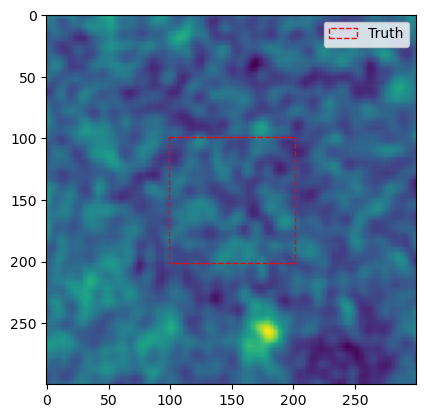

In [48]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.imshow(img[0,...])

colors = ["red", "black", "purple"]

for i in range(len(prediction[0]['boxes'])):
    if prediction[0]['scores'][i]>=0.5:
        xmin, ymin, xmax, ymax = prediction[0]['boxes'][i].cpu().numpy()
        rectangle = plt.Rectangle((xmin,ymin), xmax-xmin,ymax-ymin, fc='none',ec=colors[i], label = 'Guess')
        ax.add_patch(rectangle)
        
for i in range(len(truth['boxes'])):
    xmin, ymin, xmax, ymax = truth['boxes'][i].cpu().numpy()
    rectangle = plt.Rectangle((xmin,ymin), xmax-xmin,ymax-ymin, fc='none',ec=colors[i], linestyle = '--', label = 'Truth')
    ax.add_patch(rectangle)

plt.legend()
#plt.savefig('./figs/region_prop_{}.png'.format(j))
#plt.savefig('./figs/region_prop_{}.pdf'.format(j))

plt.show()
plt.close()

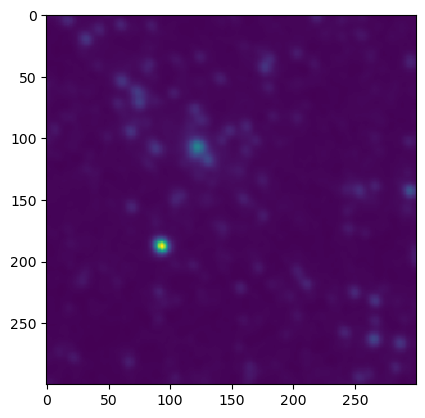

In [38]:
plt.imshow(img[...,0])